In [ ]:
#one of the requirements of the https://github.com/MedMNIST/MedMNIST provided in the assignment description
!pip install medmnist

     |████████████████████████████████| 87 kB 3.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=bfc6cd70c79da0ceb93fef885de2188f7f5f1efea386869e91b97e811a25a3be
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
#libraries and other dependencies
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#other libraries
import random
import pandas as pd

#import the sklean Logistic Regression class
from sklearn.linear_model import LogisticRegression

# B. Logistic Regression on BreastMNIST

## B1 Data loading and inspection

In [ ]:
#this part of code is reused from the github.com/MedMNIST

data_flag_breastmnist = 'breastmnist'
download = True

info_breastmnist = INFO[data_flag_breastmnist]
task_breastmnist = info_breastmnist['task']
n_channels_breastmnist = info_breastmnist['n_channels']
n_classes_breastmnist = len(info_breastmnist['label'])

DataClass_breastmnist = getattr(medmnist, info_breastmnist['python_class'])

In [ ]:
# preprocessing - images will be transformed to tensors and normalized
#this part of code is reused from the github.com/MedMNIST

BATCH_SIZE=16

data_transform_breastmnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


# load the data
train_dataset_breastmnist = DataClass_breastmnist(split='train', transform=data_transform_breastmnist, download=download)
test_dataset_breastmnist = DataClass_breastmnist(split='test', transform=data_transform_breastmnist, download=download)
val_dataset_breastmnist = DataClass_breastmnist(split='val', transform=data_transform_breastmnist, download=download)


# encapsulate data into dataloader form
train_loader_breastmnist = data.DataLoader(dataset=train_dataset_breastmnist, shuffle=True)
val_loader_breastmnist = data.DataLoader(dataset=val_dataset_breastmnist, shuffle=False)
test_loader_breastmnist = data.DataLoader(dataset=test_dataset_breastmnist, shuffle=False)

  0%|          | 0/559580 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


In [ ]:
#Display all the information and dataset description
print(train_dataset_breastmnist)
print("===================")
print(val_dataset_breastmnist)
print("===================")
print(test_dataset_breastmnist)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: /root/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 

In [ ]:
#First point: Display at least ten images for each class, i.e. at least 20 images, from the training set. 
#Display at least ten images for each class from the validation set, and display at least ten images for each class from the test set.

images_train_breastmnist = [image for image in train_dataset_breastmnist if image[1] == 0][:10] + [image for image in train_dataset_breastmnist if image[1] == 1][:10]
print("number of images in the training subset: ", len(images_train_breastmnist))

images_val_breastmnist = [image for image in val_dataset_breastmnist if image[1] == 0][:10] + [image for image in val_dataset_breastmnist if image[1] == 1][:10]
print("number of images in the validation subset: ", len(images_val_breastmnist))

images_test_breastmnist = [image for image in test_dataset_breastmnist if image[1] == 0][:10] + [image for image in test_dataset_breastmnist if image[1] == 1][:10]
print("number of images in the test subset: ", len(images_test_breastmnist))

number of images in the training subset:  20
number of images in the validation subset:  20
number of images in the test subset:  20


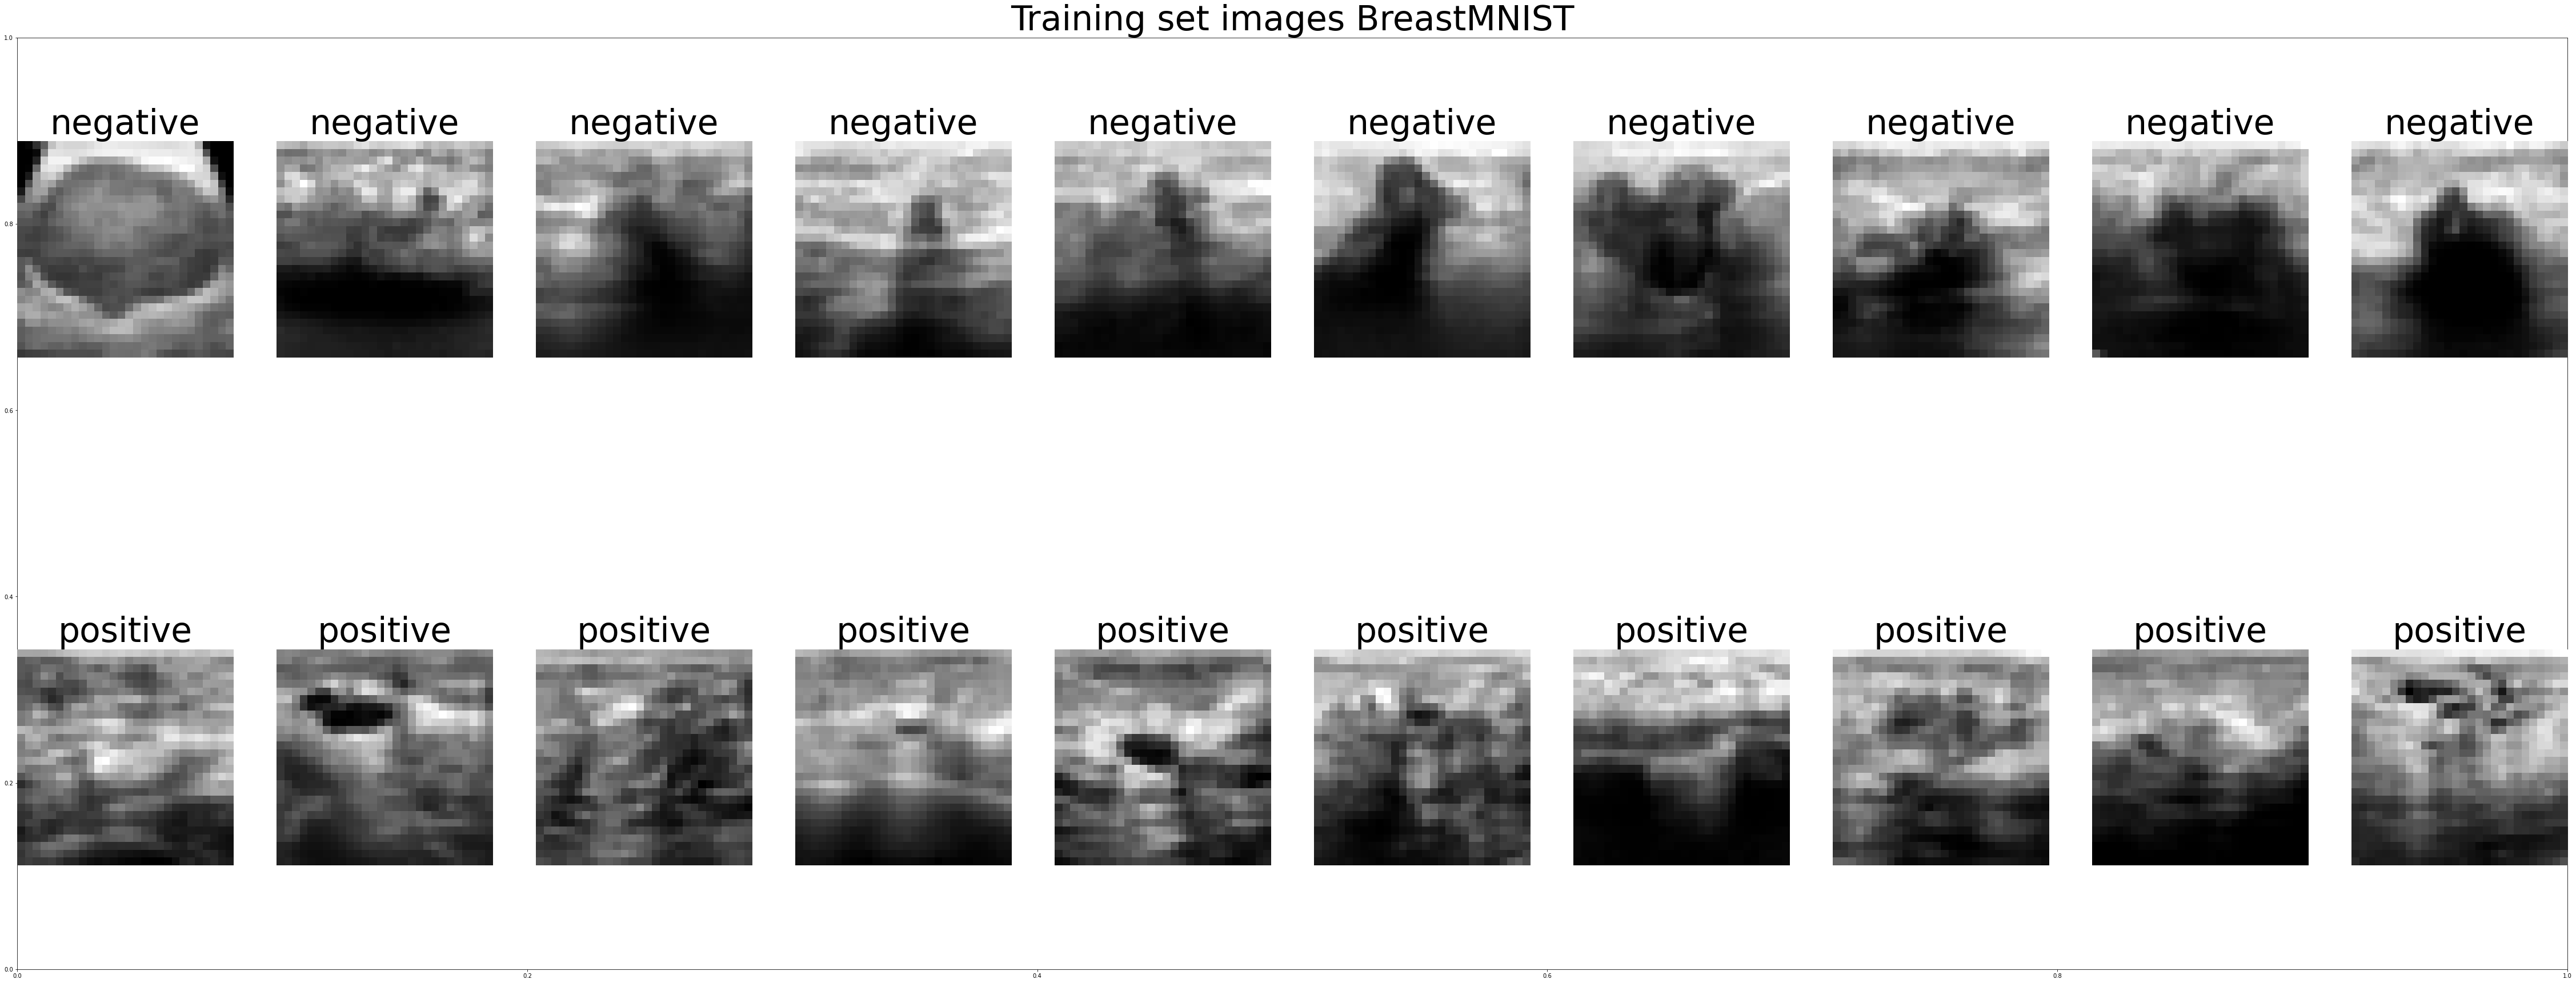

In [ ]:
#(B1) 20 images from the training set
figure = plt.figure(figsize=(80, 30))
cols, rows = 10, 2

plt.title("Training set images BreastMNIST", {'fontsize':60})
for i in range(len(images_train_breastmnist)):
    img, label = images_train_breastmnist[i]
    figure.add_subplot(rows, cols, i+1)
    if label == 0:
      plt.title("negative",{'fontsize':60})
    else:
      plt.title("positive",{'fontsize':60})
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

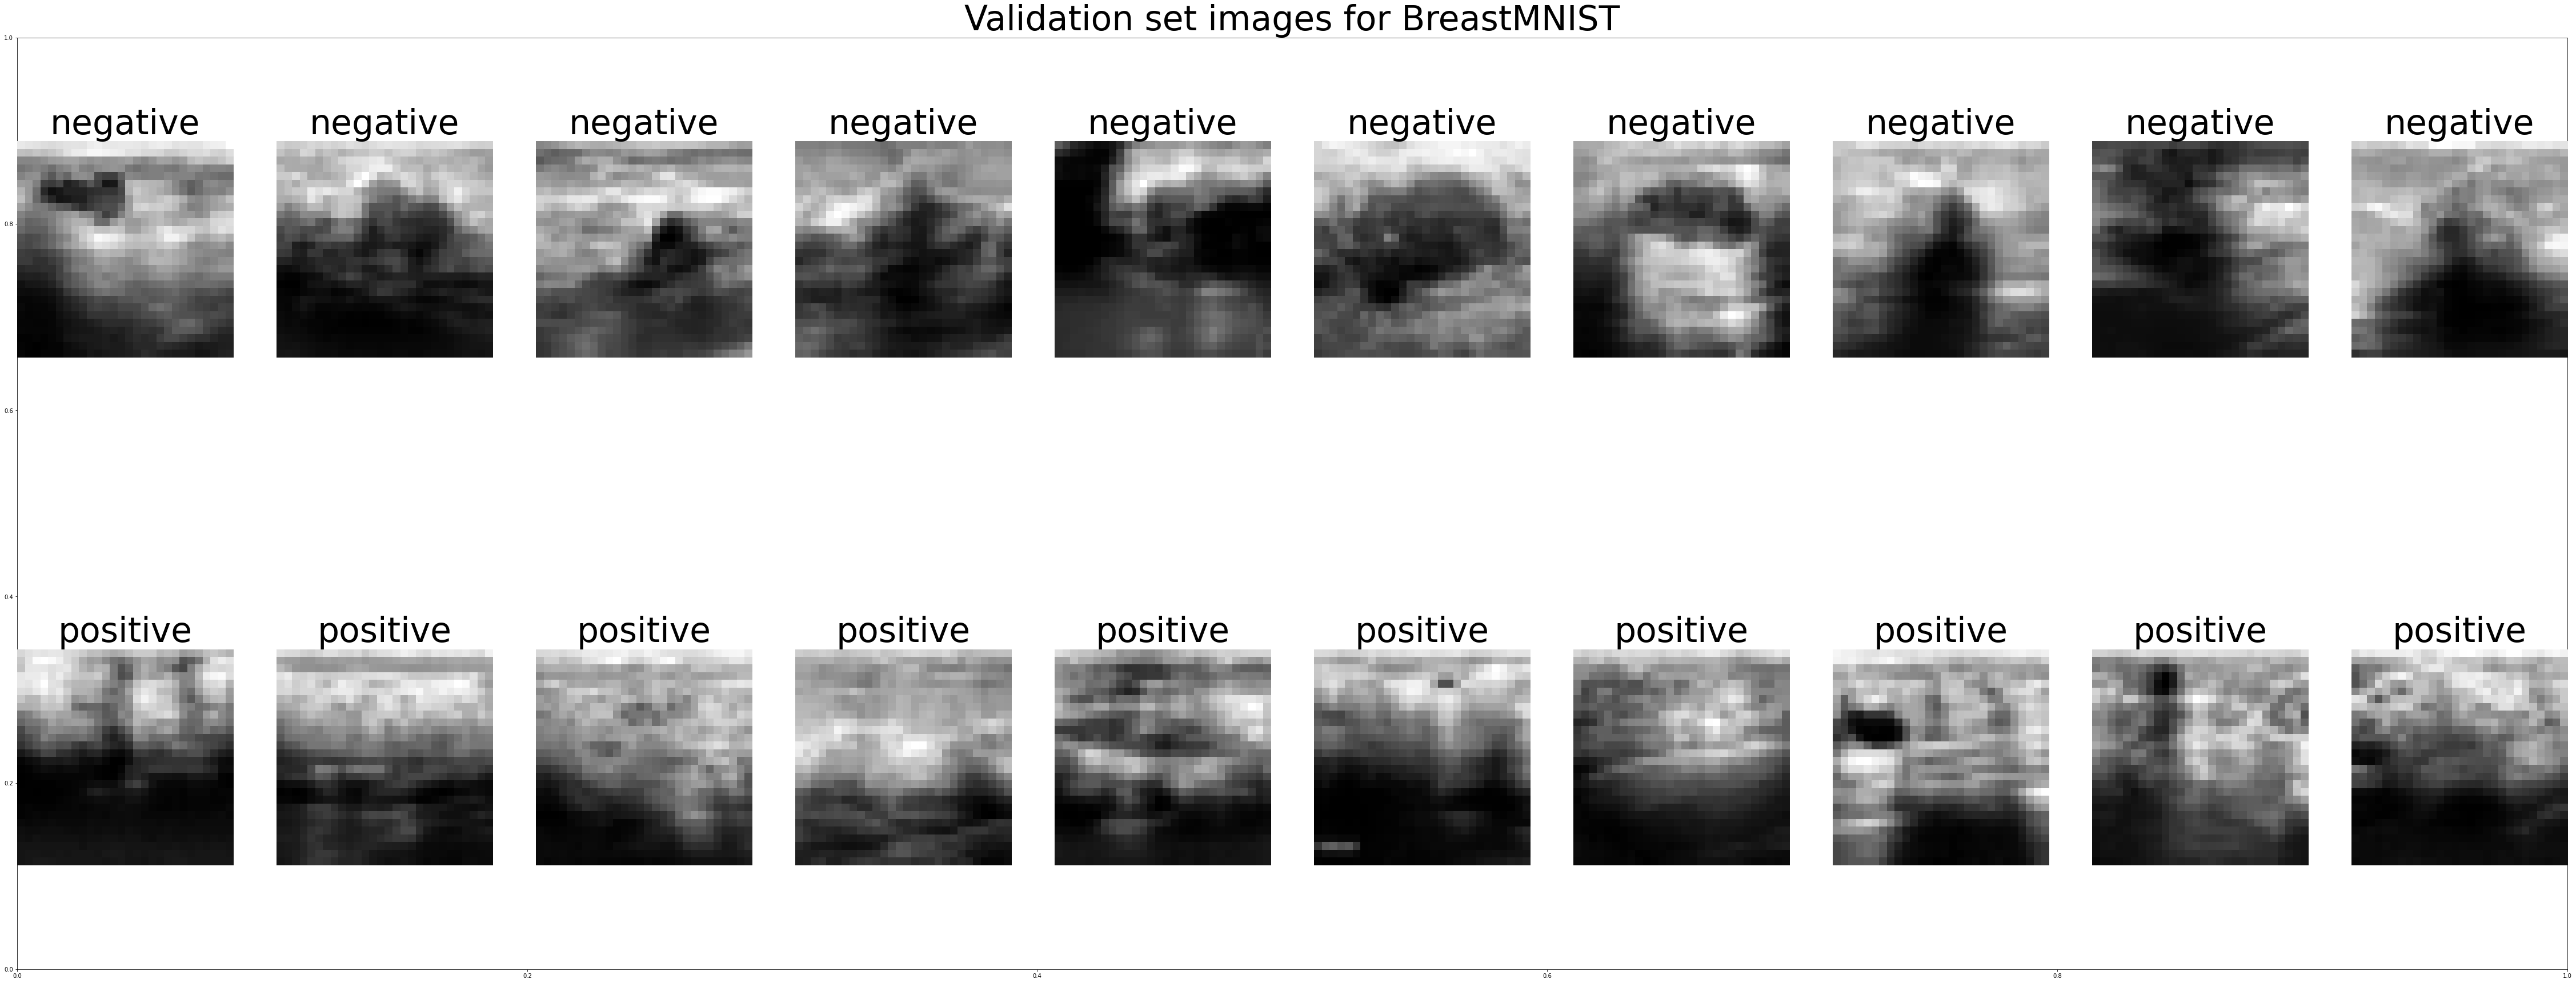

In [ ]:
#(B1) 20 images from the validation set
figure = plt.figure(figsize=(80, 30))
cols, rows = 10, 2

plt.title("Validation set images for BreastMNIST", {'fontsize':60})
for i in range(len(images_val_breastmnist)):
    img, label = images_val_breastmnist[i]
    figure.add_subplot(rows, cols, i+1)
    if label == 0:
      plt.title("negative",{'fontsize':60})
    else:
      plt.title("positive",{'fontsize':60})
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

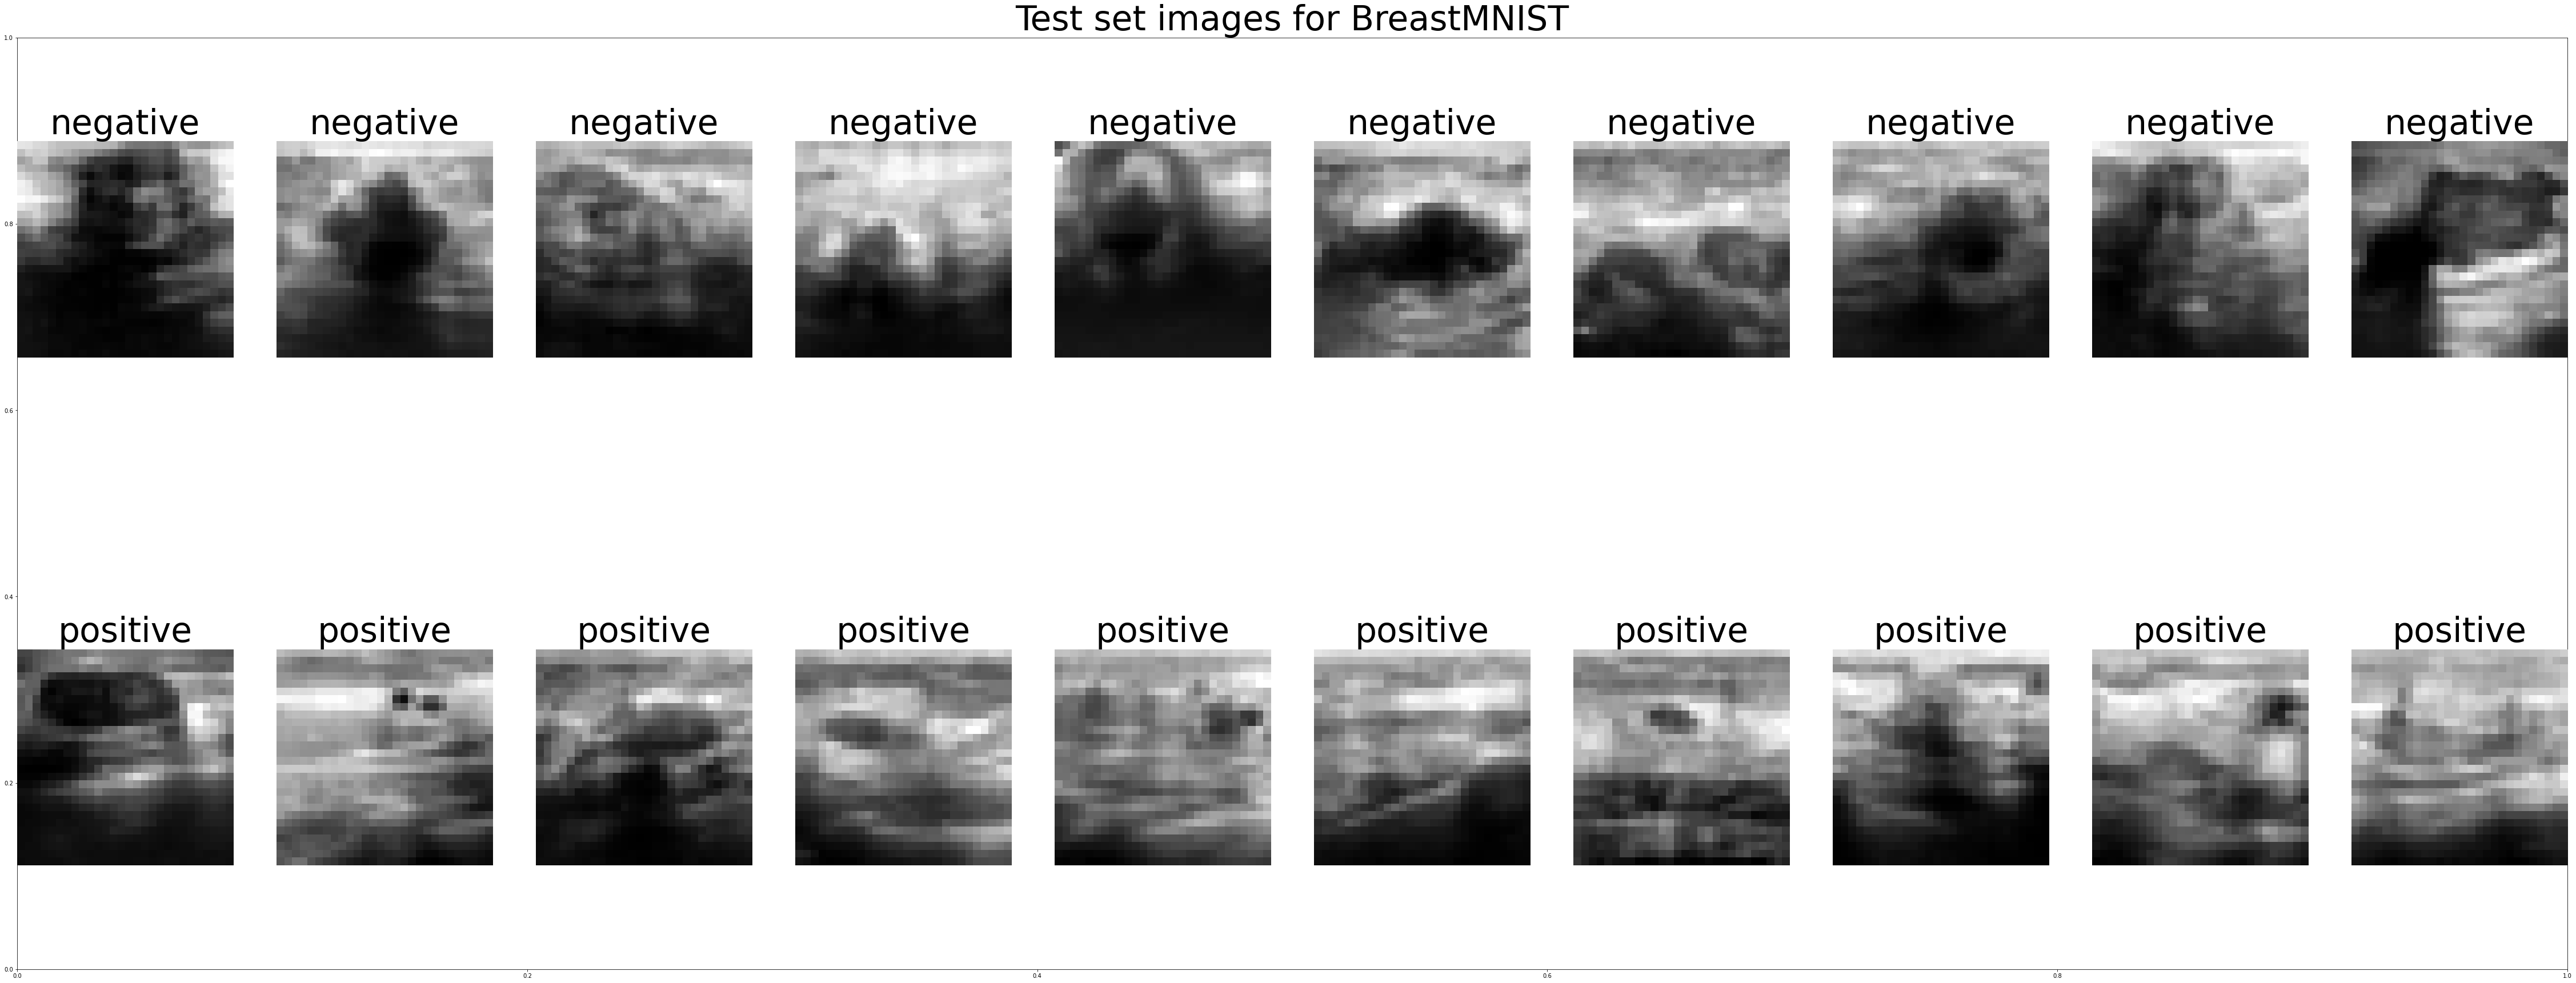

In [ ]:
#(B1) 20 images from the test set
figure = plt.figure(figsize=(80, 30))
cols, rows = 10, 2

plt.title("Test set images for BreastMNIST", {'fontsize':60})
for i in range(len(images_test_breastmnist)):
    img, label = images_test_breastmnist[i]
    figure.add_subplot(rows, cols, i+1)
    if label == 0:
      plt.title("negative",{'fontsize':60})
    else:
      plt.title("positive",{'fontsize':60})
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## B2 Logistic regression

In [ ]:
#Three accuracy metrics required in the assignment doc

#M1 - Training accuracy
#M2 - Validation accuracy
#M3 - Testing accuracy

In [ ]:
#before data can be applied to the supervised model it needs to be splitted to features and target datapoints

#features are converted from tensors to numpy arrays and flatten 28*82=784
xTrain_breastmnist = [image[0].numpy().reshape(784) for image in train_dataset_breastmnist]
xVal_breastmnist = [image[0].numpy().reshape(784) for image in val_dataset_breastmnist]
xTest_breastmnist = [image[0].numpy().reshape(784) for image in test_dataset_breastmnist]

#target points
yTrain_breastmnist = [image[1] for image in train_dataset_breastmnist]
yVal_breastmnist = [image[1] for image in val_dataset_breastmnist]
yTest_breastmnist = [image[1] for image in test_dataset_breastmnist]


#converting the list to numpy array
yTrain_breastmnist = np.array(yTrain_breastmnist)
yVal_breastmnist = np.array(yVal_breastmnist)
yTest_breastmnist = np.array(yTest_breastmnist)

In [ ]:
#(B2) Using the built-in logistic regression functions in scikit-learn, train a logistic regression model with L2 regularisation on the training set, use 
#the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. 
#Report the three metrics M1 to M3



#grid of the L2 parameters
l2_parameter = np.linspace(0.001,0.1,20)

#set a seed for reproducibility
np.random.seed(70629) 
torch.manual_seed(70629)
random.seed(70629)

best_acc = 0

#list created for the results storage
results_grid_sklearn = []

for l2 in l2_parameter:
  #set a random_state for reproducibility
  model_breastmnist = LogisticRegression(max_iter=500, penalty='l2', C=l2, random_state=70629)
  model_breastmnist.fit(xTrain_breastmnist,yTrain_breastmnist.ravel())

  #accuracy evaluation
  train_acc_breastmnist = model_breastmnist.score(xTrain_breastmnist, yTrain_breastmnist.ravel())
  val_acc_breastmnist = model_breastmnist.score(xVal_breastmnist, yVal_breastmnist.ravel())
  test_acc_breastmnist = model_breastmnist.score(xTest_breastmnist, yTest_breastmnist.ravel())

  #adding a new results layer to the results grid
  results_grid_sklearn.append([l2, train_acc_breastmnist, val_acc_breastmnist, test_acc_breastmnist])

  #displaying only the results reaching hgiher accuracy than other configs
  if val_acc_breastmnist > best_acc:
    print('BEST validation accuracy for validation set is: {} % for l2: {}'.format(round((val_acc_breastmnist*100),2), l2)) 
    best_acc = val_acc_breastmnist

BEST validation accuracy for validation set is: 73.08 % for l2: 0.001
BEST validation accuracy for validation set is: 84.62 % for l2: 0.006210526315789474
BEST validation accuracy for validation set is: 85.9 % for l2: 0.01663157894736842


In [ ]:
#displaying the grid with the accuracy results in the dataframe form
results_grid_sklearn = pd.DataFrame(results_grid_sklearn, columns=["L2 parameter","(M1)Train accuracy", "(M2)Validation accuracy","(M3)Test accuracy"])
results_grid_sklearn

,L2 parameter,(M1)Train accuracy,(M2)Validation accuracy,(M3)Test accuracy
0,0.001000,0.736264,0.730769,0.730769
1,0.006211,0.793040,0.846154,0.775641
2,0.011421,0.807692,0.846154,0.794872
3,0.016632,0.818681,0.858974,0.794872
4,0.021842,0.818681,0.858974,0.807692
5,0.027053,0.822344,0.858974,0.807692
6,0.032263,0.827839,0.858974,0.801282
7,0.037474,0.831502,0.858974,0.801282
8,0.042684,0.835165,0.858974,0.801282
9,0.047895,0.840659,0.858974,0.801282


In [ ]:
#features are converted from tensors to numpy arrays and flatten 28*82=784
xTrain_breastmnist_pytorch = [image[0] for image in train_dataset_breastmnist]
xVal_breastmnist_pytorch = [image[0] for image in val_dataset_breastmnist]
xTest_breastmnist_pytorch = [image[0] for image in test_dataset_breastmnist]

In [ ]:
# Logistic Regression Pytorch model implementation
class LogisticRegression(torch.nn.Module):
    
    def __init__(self):
        
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(784, 1)     
        
    def forward(self, x):
            y_pred = torch.sigmoid(self.linear(x))
            return y_pred
  

In [ ]:
# now learn the classification/decision boundary for this synthestic data
# using the logistic regression function created in the cell above
#create the criterion for the loss measurement in logistic regression nn:
#the loss here will be based on the discrepancy between the predicted binary
#output class by the network and the actual class of the data, this is called 
# binary cross entropy (also known as binary logarithmic loss function).


#function to calculate the accuracy
def accu_calc(x_data,y_data, LR):
  acccu_val = 0
  for sample in range(len(x_data)):

    pred = LR(x_data[sample].reshape(784))
    if pred > 0.5:
      pred = [1]
    else:
      pred= [0]
    if pred == y_data[sample]:
      acccu_val +=1
  return acccu_val/len(x_data)

results_grid_pytorch = []
l2_parameter = np.linspace(0.001,0.1,20)
best_accu_pytorch = 0

for l2 in l2_parameter:
  #set a seed for reproducibility
  np.random.seed(70629) 
  torch.manual_seed(70629)
  random.seed(70629)

  #instance of the Logistic regression initialization
  LR=LogisticRegression()
  opt = torch.optim.SGD(LR.parameters(), lr=0.01)
  #loss function initialization
  criterion = torch.nn.BCELoss()

  reg_lambda = l2
  iterations = len(train_loader_breastmnist.dataset)

  for iteration in range(iterations):
      x_breast_pytorch, y_breast_pytorch = next(iter(train_loader_breastmnist))

      # Reset gradients
      
        
      LR.zero_grad()

      # Forward pass
      x_breast_pytorch = x_breast_pytorch.reshape(1,784)
      LR_x = LR(x_breast_pytorch)

      #regularization initialization
      reg = 0
      for param in LR.parameters():
        reg += 0.5 * (param ** 2).sum() 
      output = criterion(LR_x, y_breast_pytorch.float()) + reg_lambda * reg
      loss = output.item()

      output.backward()

      # Gradients
      for param in LR.parameters():
          param.data.add_(-0.5 * param.grad.data)



  val_accu = accu_calc(xVal_breastmnist_pytorch,yVal_breastmnist,LR)
  train_accu = accu_calc(xTrain_breastmnist_pytorch,yTrain_breastmnist,LR)
  test_accu = accu_calc(xTest_breastmnist_pytorch,yTest_breastmnist,LR)
  if val_accu > best_accu_pytorch:
    print('New best accuracy val: {}% for l2: {}'.format(round(val_accu*100,2), l2))
    best_accu_pytorch = val_accu
  results_grid_pytorch.append([l2, train_accu, val_accu, test_accu])


New best accuracy val: 73.08% for l2: 0.001
New best accuracy val: 74.36% for l2: 0.01663157894736842


In [ ]:
#displaying the grid with the accuracy results in the dataframe form
results_grid_pytorch = pd.DataFrame(results_grid_pytorch, columns=["L2 parameter","(M1)Train accuracy", "(M2)Validation accuracy","(M3)Test accuracy"])
results_grid_pytorch

,L2 parameter,(M1)Train accuracy,(M2)Validation accuracy,(M3)Test accuracy
0,0.001000,0.728938,0.730769,0.730769
1,0.006211,0.728938,0.730769,0.730769
2,0.011421,0.725275,0.730769,0.717949
3,0.016632,0.719780,0.743590,0.737179
4,0.021842,0.285714,0.282051,0.301282
5,0.027053,0.719780,0.743590,0.730769
6,0.032263,0.723443,0.743590,0.724359
7,0.037474,0.725275,0.730769,0.724359
8,0.042684,0.296703,0.294872,0.314103
9,0.047895,0.710623,0.730769,0.717949


## B3 Performance comparison

In [ ]:
#preparing the results for the bar plotting
l2_grid_sklearn = results_grid_sklearn.iloc[:,0]
l2_grid_sklearn = [str(value) for value in l2_grid_sklearn]
train_grid_sklearn = results_grid_sklearn.iloc[:,1]
val_grid_sklearn = results_grid_sklearn.iloc[:,2]
test_grid_sklearn = results_grid_sklearn.iloc[:,3]

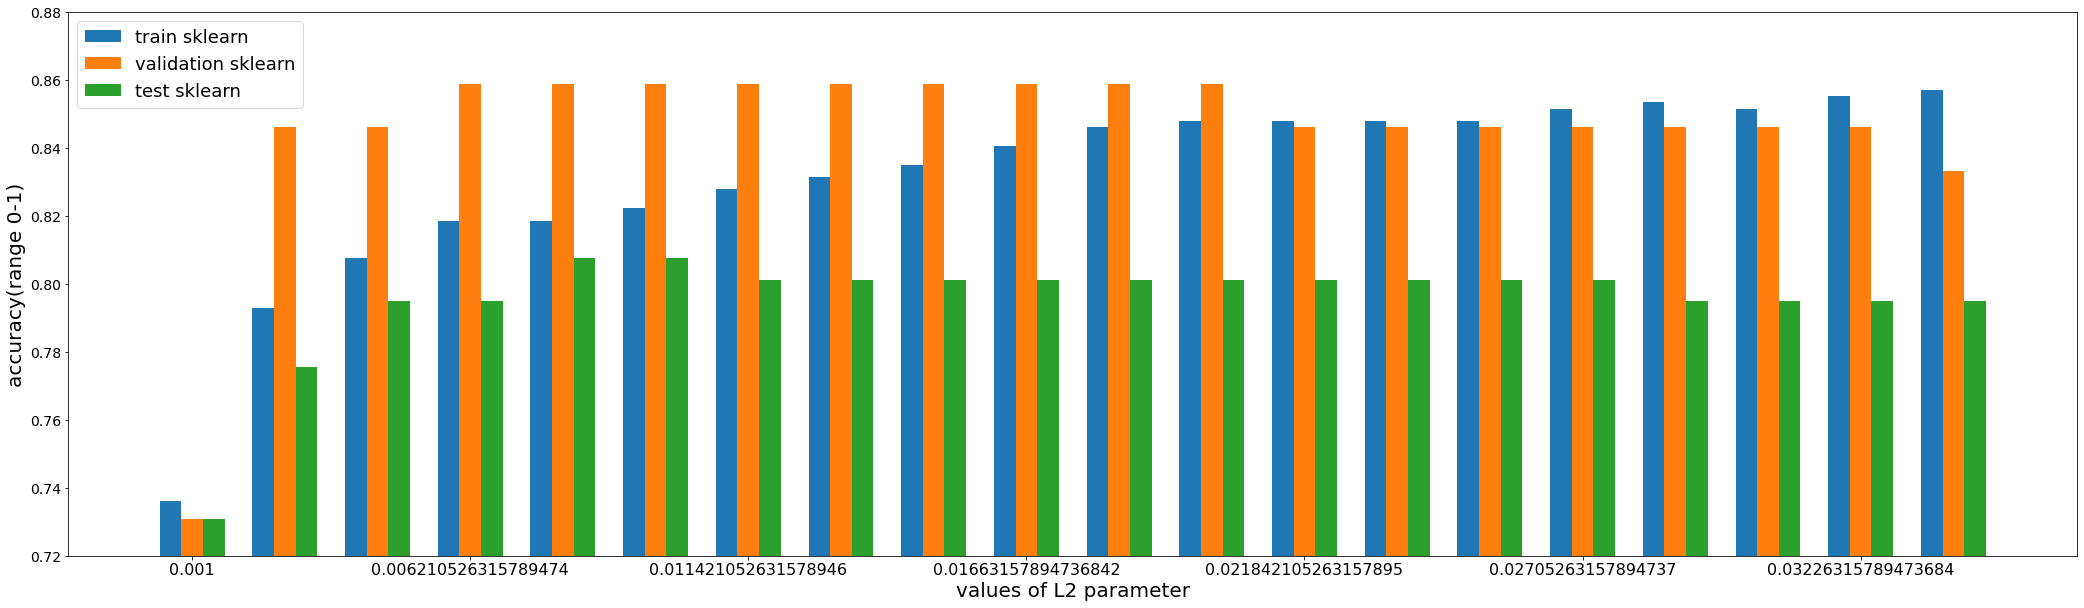

In [ ]:
#Bar graph - Summarise each of the three metrics from the two chosen models in B2 using one or more bar graphs.
def subcategorybar(X, vals, labels, ylim1, ylim2, width=0.7):
    f, ax = plt.subplots(figsize=(36,10))
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X, fontsize=16)
    plt.yticks(fontsize=14)
    plt.locator_params(nbins=9)
    plt.legend(labels=labels, fontsize=18)
    #it is used to make the results differ from each other
    plt.ylim(ylim1, ylim2)
    plt.xlabel('values of L2 parameter', fontsize=20)
    plt.ylabel('accuracy(range 0-1)', fontsize=20)

subcategorybar(l2_grid_sklearn, [train_grid_sklearn,val_grid_sklearn,test_grid_sklearn], ylim1 = 0.72, ylim2 = 0.88, labels=["train sklearn","validation sklearn","test sklearn"])


In [ ]:
#preparing the results for the bar plotting
l2_grid_pytorch = results_grid_pytorch.iloc[:,0]
l2_grid_pytorch = [str(value) for value in l2_grid_pytorch]
train_grid_pytorch = results_grid_pytorch.iloc[:,1]
val_grid_pytorch = results_grid_pytorch.iloc[:,2]
test_grid_pytorch = results_grid_pytorch.iloc[:,3]

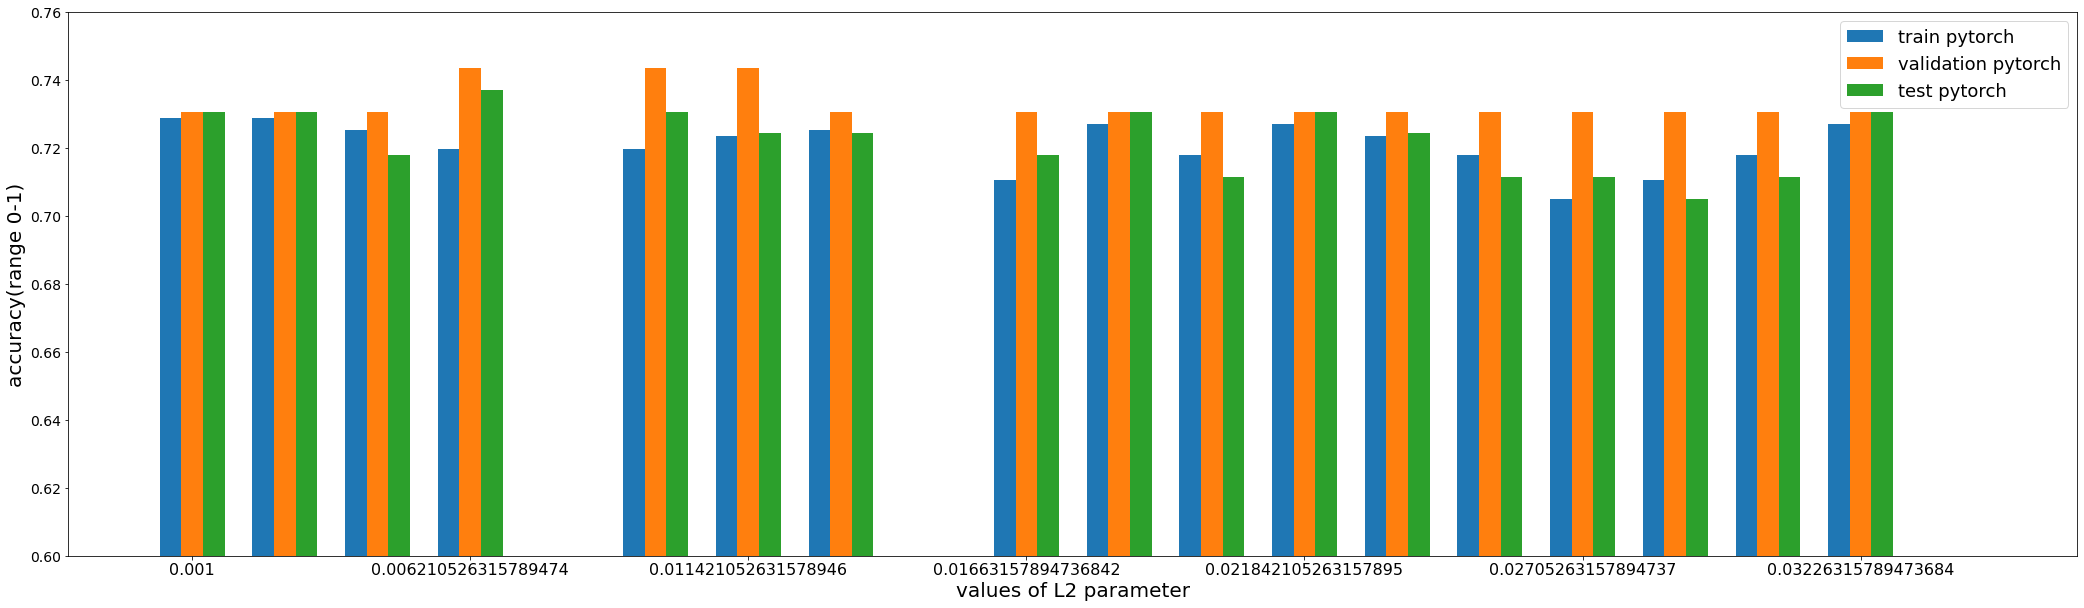

In [ ]:
#Bar graph - Summarise each of the three metrics from the two chosen models in B2 using one or more bar graphs.

subcategorybar(l2_grid_pytorch, [train_grid_pytorch,val_grid_pytorch,test_grid_pytorch], ylim1 = 0.6, ylim2 = 0.76,labels=["train pytorch","validation pytorch","test pytorch"],)

### B3.2 Interesting observations
####1. Comparing the results obtained with pytorch and sklearn Logistic Regression implementation it can be noticed that despite they produce different accuracy values, both indicate the same value of L2 parameter as the one giving the best score.

####2. Another observation derived from the bar graphs can be the trends of accuracy values vs L2 parameter values. Sklearn tends to be more stable with a peak at the 0.01663157894736842 and a slight decrease for the higher L2 values.
#### In case of Pytorch fluctuations exist, especially for the test set and results are less predictible. Only validation set seems to follow similar pattern to the validation set applied on sklearn.  

# C. Convolutional Neural Networks on OCTMNIST

## C1 Data loading and inspection

In [ ]:
data_flag_octmnist = 'octmnist'
download = True

BATCH_SIZE = 128

info_octmnist = INFO[data_flag_octmnist]
task_octmnist = info_octmnist['task']
n_channels_octmnist = info_octmnist['n_channels']
n_classes_octmnist = len(info_octmnist['label'])

DataClass_octmnist = getattr(medmnist, info_octmnist['python_class'])

In [ ]:
# preprocessing

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


# load the data
train_dataset_octmnist = DataClass_octmnist(split='train', transform=data_transform, download=download)
test_dataset_octmnist = DataClass_octmnist(split='test', transform=data_transform, download=download)
val_dataset_octmnist = DataClass_octmnist(split='val', transform=data_transform, download=download)

#pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader_octmnist = data.DataLoader(dataset=train_dataset_octmnist, batch_size=BATCH_SIZE, shuffle=True)
val_loader_octmnist = data.DataLoader(dataset=val_dataset_octmnist, batch_size=BATCH_SIZE, shuffle=False)
test_loader_octmnist = data.DataLoader(dataset=test_dataset_octmnist, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [ ]:
print(train_dataset_octmnist)
print("===================")
print(val_dataset_octmnist)
print("===================")
print(test_dataset_octmnist)

Dataset OCTMNIST (octmnist)
    Number of datapoints: 97477
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset OCTMNIST (octmnist)
    Number of datapoints: 10832
    Root location: /root/.medmnist
    Split: val
    Task:

In [ ]:
#prepare the set of images to display
images_train_octmnist = [image for image in train_dataset_octmnist if image[1] == 0][:10] + [image for image in train_dataset_octmnist if image[1] == 1][:10] + [image for image in train_dataset_octmnist if image[1] == 2][:10] + [image for image in train_dataset_octmnist if image[1] == 3][:10]
print("number of images in the train subset: ", len(images_train_octmnist))

number of images in the train subset:  40


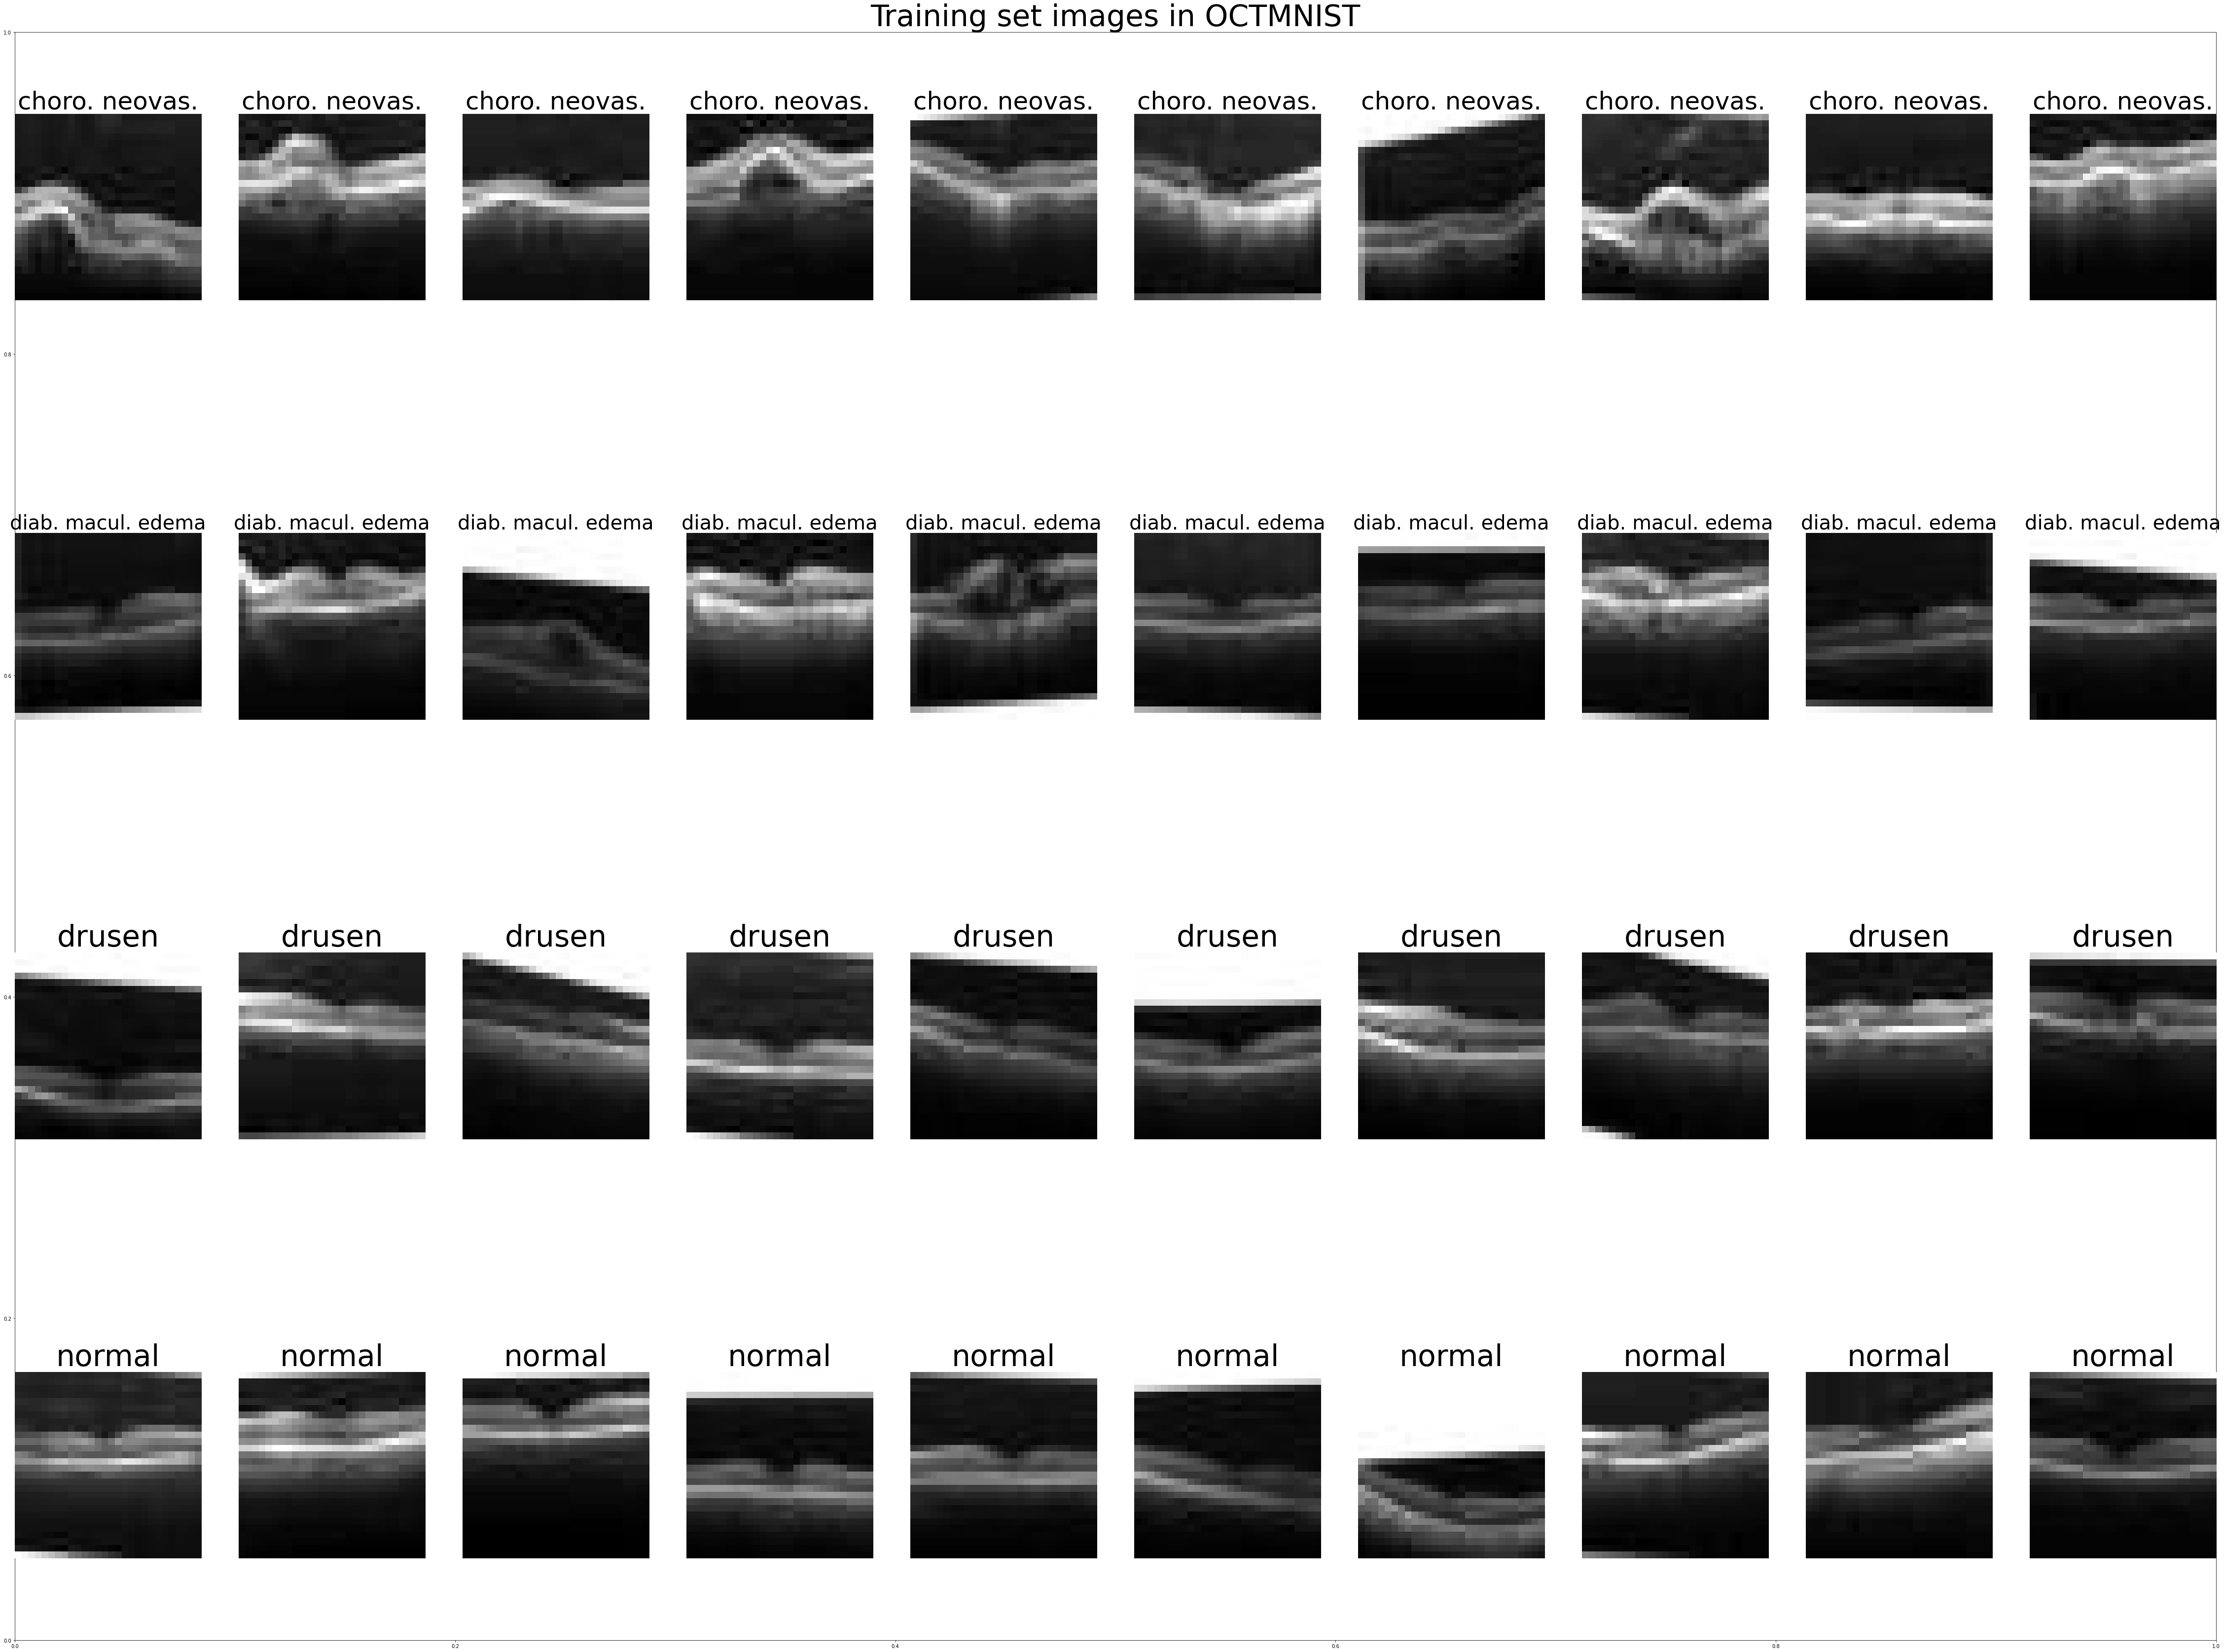

In [ ]:
#Display at least ten images for each class, i.e. at least 40 images, from the training set. 

#(B1) 20 images from the training set
figure = plt.figure(figsize=(80, 60))
cols, rows = 10, 4

plt.title("Training set images in OCTMNIST", {'fontsize':60})
for i in range(len(images_train_octmnist)):
    img, label = images_train_octmnist[i]
    figure.add_subplot(rows, cols, i+1)
    if label == 0:
      plt.title("choro. neovas.",{'fontsize':50})
    elif label == 1:
      plt.title("diab. macul. edema",{'fontsize':40})
    elif label == 2:
      plt.title("drusen",{'fontsize':60})
    elif label == 3:
      plt.title("normal",{'fontsize':60})
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## C2 Convolutional Neural Network

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'octmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 1
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_set = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=validation_set, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


### CNN three Conv layers and three FC layers Configuration

In [ ]:
# three Conv layers and three FC layers

######EXPLANATION OF EXPERIMENTS#########
#For both three and two conv models there are 5 configurations planned. 1 is standard and will be used as a base while 4 others
#are splitted into 2 models with larger and smaller conv layers and 2 models with larger and smaller FC layers.

#learning rate and loss function
lr = 0.001
criterion = nn.CrossEntropyLoss()

#first configuration: 3 conv layers: 16, 16, 64 and 3 FC layers: 128, 64,4
class ThreeConv_1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ThreeConv_1, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


model_ThreeConv_1 = ThreeConv_1(in_channels=n_channels, num_classes=n_classes)    
optimizer_ThreeConv_1 = optim.SGD(model_ThreeConv_1.parameters(), lr=lr, momentum=0.9)

In [ ]:
# three Conv layers and three FC layers

#second configuration: 3 conv layers: 16, 16, 64 and 3 FC layers: 128, 64,4
class ThreeConv_2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ThreeConv_2, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_ThreeConv_2 = ThreeConv_2(in_channels=n_channels, num_classes=n_classes)    
optimizer_ThreeConv_2 = optim.SGD(model_ThreeConv_2.parameters(), lr=lr, momentum=0.9)

In [ ]:
# three Conv layers and three FC layers

class ThreeConv_3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ThreeConv_3, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(8 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_ThreeConv_3 = ThreeConv_3(in_channels=n_channels, num_classes=n_classes)
optimizer_ThreeConv_3 = optim.SGD(model_ThreeConv_3.parameters(), lr=lr_2, momentum=0.9)

### CNN two Conv layers and two FC layers Configuration

In [ ]:
# three Conv layers and three FC layers

class TwoConv_1(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(TwoConv_1, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_TwoConv_1 = TwoConv_1(in_channels=n_channels, num_classes=n_classes)
optimizer_TwoConv_1 = optim.SGD(model_TwoConv_1.parameters(), lr=lr_2, momentum=0.9)

In [ ]:
# three Conv layers and three FC layers

class TwoConv_2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(TwoConv_2, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6, stride=6))

        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_TwoConv_2 = TwoConv_2(in_channels=n_channels, num_classes=n_classes)
optimizer_TwoConv_2 = optim.SGD(model_TwoConv_2.parameters(), lr=lr_2, momentum=0.9)

In [ ]:
# three Conv layers and three FC layers

class TwoConv_3(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(TwoConv_3, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3))

        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model_TwoConv_3 = TwoConv_3(in_channels=n_channels, num_classes=n_classes)
optimizer_TwoConv_3 = optim.SGD(model_TwoConv_3.parameters(), lr=lr_2, momentum=0.9)

In [ ]:
# defining train function
import timeit

def train(epochs, model_train, optimizer):
  #reproducibility seeds:
  np.random.seed(70629)
  # Set random seed for pytorch
  torch.manual_seed(70629)

  for epoch in range(epochs):
      
      model_train.train()
      for inputs, targets in tqdm(train_loader_octmnist):
          optimizer.zero_grad()
          outputs = model_train(inputs)
          
          targets = targets.squeeze().long()
          loss = criterion(outputs, targets)
          
          loss.backward()
          optimizer.step()
"""
#calling train function
start = timeit.default_timer()
train(2, model_ThreeConv_1, optimizer_ThreeConv_1)
stop = timeit.default_timer()

duration = stop - start
print('start {}, stop {}, duration {} seconds'.format(start, stop, duration))
"""

"\n#calling train function\nstart = timeit.default_timer()\ntrain(2, model_ThreeConv_1, optimizer_ThreeConv_1)\nstop = timeit.default_timer()\n\nduration = stop - start\nprint('start {}, stop {}, duration {} seconds'.format(start, stop, duration))\n"

In [ ]:
# evaluation

def test(split, trained_model):
    trained_model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    if split == "train":
      data_loader = train_loader_octmnist 
    elif split == "val":
      data_loader = val_loader_octmnist 
    elif split == "test":
      data_loader = test_loader_octmnist 
    else:
      return "type of split has not been recognized"

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = trained_model(inputs)
           
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        return metrics


In [ ]:
##### Experimnets with two layers:

cnn_results = []

#configuration 1
model_name = 'TwoConv_1'
start = timeit.default_timer()
train(2, model_TwoConv_1, optimizer_TwoConv_1)
stop = timeit.default_timer()
duration = stop - start

train_acc = test('train', model_TwoConv_1)
val_acc = test('val', model_TwoConv_1)
test_acc = test('test', model_TwoConv_1)

cnn_results.append([model_name, duration, train_acc.ACC, val_acc.ACC, test_acc.ACC])

#configuration 2
model_name = 'TwoConv_2'
start = timeit.default_timer()
train(2, model_TwoConv_2, optimizer_TwoConv_2)
stop = timeit.default_timer()
duration = stop - start

train_acc = test('train', model_TwoConv_2)
val_acc = test('val', model_TwoConv_2)
test_acc = test('test', model_TwoConv_2)

cnn_results.append([model_name, duration, train_acc.ACC, val_acc.ACC, test_acc.ACC])

#configuration 3
model_name = 'TwoConv_3'
start = timeit.default_timer()
train(2, model_TwoConv_3, optimizer_TwoConv_3)
stop = timeit.default_timer()
duration = stop - start

train_acc = test('train', model_TwoConv_3)
val_acc = test('val', model_TwoConv_3)
test_acc = test('test', model_TwoConv_3)

cnn_results.append([model_name, duration, train_acc.ACC, val_acc.ACC, test_acc.ACC])

100%|██████████| 762/762 [02:47<00:00,  4.56it/s]


train  auc: 0.498  acc:0.355
val  auc: 0.951  acc:0.861
test  auc: 0.926  acc:0.689


100%|██████████| 762/762 [06:10<00:00,  2.06it/s]


train  auc: 0.498  acc:0.382
val  auc: 0.940  acc:0.855
test  auc: 0.919  acc:0.624


100%|██████████| 762/762 [02:24<00:00,  5.29it/s]


train  auc: 0.497  acc:0.398
val  auc: 0.923  acc:0.832
test  auc: 0.907  acc:0.569


In [ ]:
cnn_results = pd.DataFrame(cnn_results, columns=["cnn name", "duration(sec)", "train accuracy", "validation accuracy","test accuracy"]).style.hide_index()
cnn_results

cnn name,duration(sec),train accuracy,validation accuracy,test accuracy
TwoConv_1,333.878150,0.354607,0.860506,0.689000
TwoConv_2,740.599854,0.381823,0.855244,0.624000
TwoConv_3,287.872478,0.397807,0.832072,0.569000


In [ ]:
##### Experimnets with three layers:

cnn_results_three = []

#configuration 1
model_name = 'ThreeConv_1'
start = timeit.default_timer()
train(2, model_ThreeConv_1, optimizer_ThreeConv_1)
stop = timeit.default_timer()
duration = stop - start

train_acc = test('train', model_ThreeConv_1)
val_acc = test('val', model_ThreeConv_1)
test_acc = test('test', model_ThreeConv_1)

cnn_results_three.append([model_name, duration, train_acc.ACC, val_acc.ACC, test_acc.ACC])

#configuration 2
model_name = 'ThreeConv_2'
start = timeit.default_timer()
train(2, model_ThreeConv_2, optimizer_ThreeConv_2)
stop = timeit.default_timer()
duration = stop - start

train_acc = test('train', model_ThreeConv_2)
val_acc = test('val', model_ThreeConv_2)
test_acc = test('test', model_ThreeConv_2)

cnn_results_three.append([model_name, duration, train_acc.ACC, val_acc.ACC, test_acc.ACC])

#configuration 3
model_name = 'ThreeConv_3'
start = timeit.default_timer()
train(2, model_ThreeConv_3, optimizer_ThreeConv_3)
stop = timeit.default_timer()
duration = stop - start

train_acc = test('train', model_ThreeConv_3)
val_acc = test('val', model_ThreeConv_3)
test_acc = test('test', model_ThreeConv_3)

cnn_results_three.append([model_name, duration, train_acc.ACC, val_acc.ACC, test_acc.ACC])

100%|██████████| 762/762 [01:30<00:00,  8.43it/s]


train  auc: 0.497  acc:0.383
val  auc: 0.921  acc:0.835
test  auc: 0.905  acc:0.645


100%|██████████| 762/762 [03:10<00:00,  4.00it/s]


train  auc: 0.498  acc:0.382
val  auc: 0.922  acc:0.830
test  auc: 0.925  acc:0.679


100%|██████████| 762/762 [01:14<00:00, 10.26it/s]


train  auc: 0.497  acc:0.389
val  auc: 0.898  acc:0.816
test  auc: 0.862  acc:0.560


In [ ]:
cnn_results_three = pd.DataFrame(cnn_results_three, columns=["cnn name", "duration(sec)", "train accuracy", "validation accuracy","test accuracy"]).style.hide_index()
cnn_results_three

cnn name,duration(sec),train accuracy,validation accuracy,test accuracy
ThreeConv_1,180.897260,0.383455,0.834564,0.645000
ThreeConv_2,380.395690,0.382429,0.829948,0.679000
ThreeConv_3,148.525420,0.389117,0.816377,0.560000


## C3 Performance Comparison

### C3.1 Bar Graphs - Convolutional Neural Networks

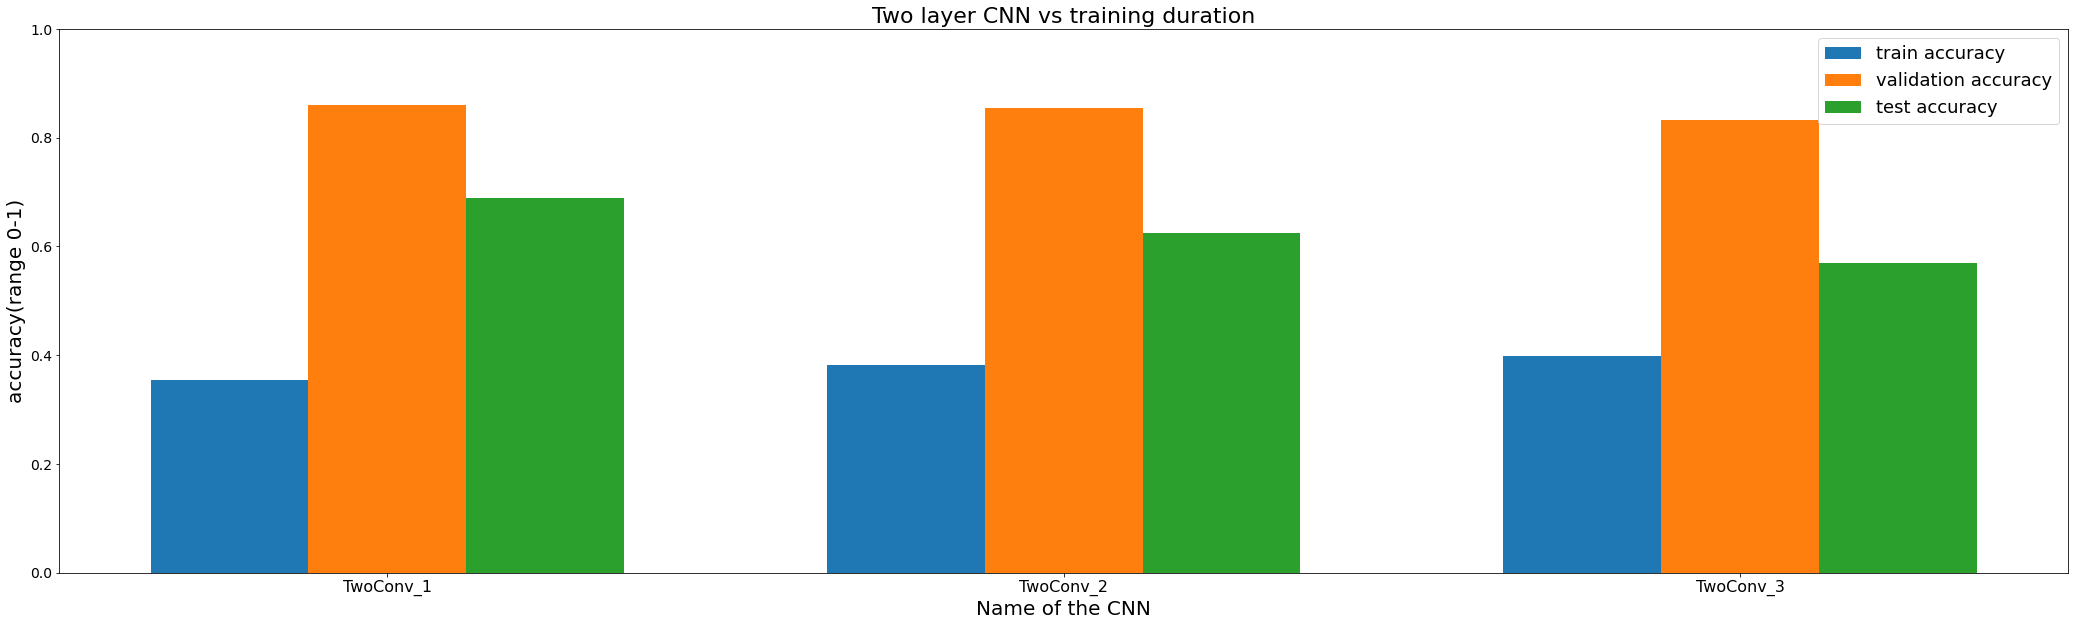

In [ ]:
#bar plot for the TwoConv CNN configuration
def subcategorybar2(X, vals, labels, ylim1, ylim2, width=0.7):
    f, ax = plt.subplots(figsize=(36,10))
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X, fontsize=16)
    plt.yticks(fontsize=14)
    plt.locator_params(nbins=9)
    plt.legend(labels=labels, fontsize=18)
    #it is used to make the results differ from each other
    plt.ylim(ylim1, ylim2)
    plt.xlabel('Name of the CNN', fontsize=20)
    plt.ylabel('accuracy(range 0-1)', fontsize=20)
    plt.title('Two layer CNN vs training duration', fontsize = 22)

subcategorybar2(cnn_results.iloc[:,0], [cnn_results.iloc[:,2],cnn_results.iloc[:,3], cnn_results.iloc[:,4]], ylim1 = 0, ylim2 = 1, labels=["train accuracy","validation accuracy","test accuracy"])

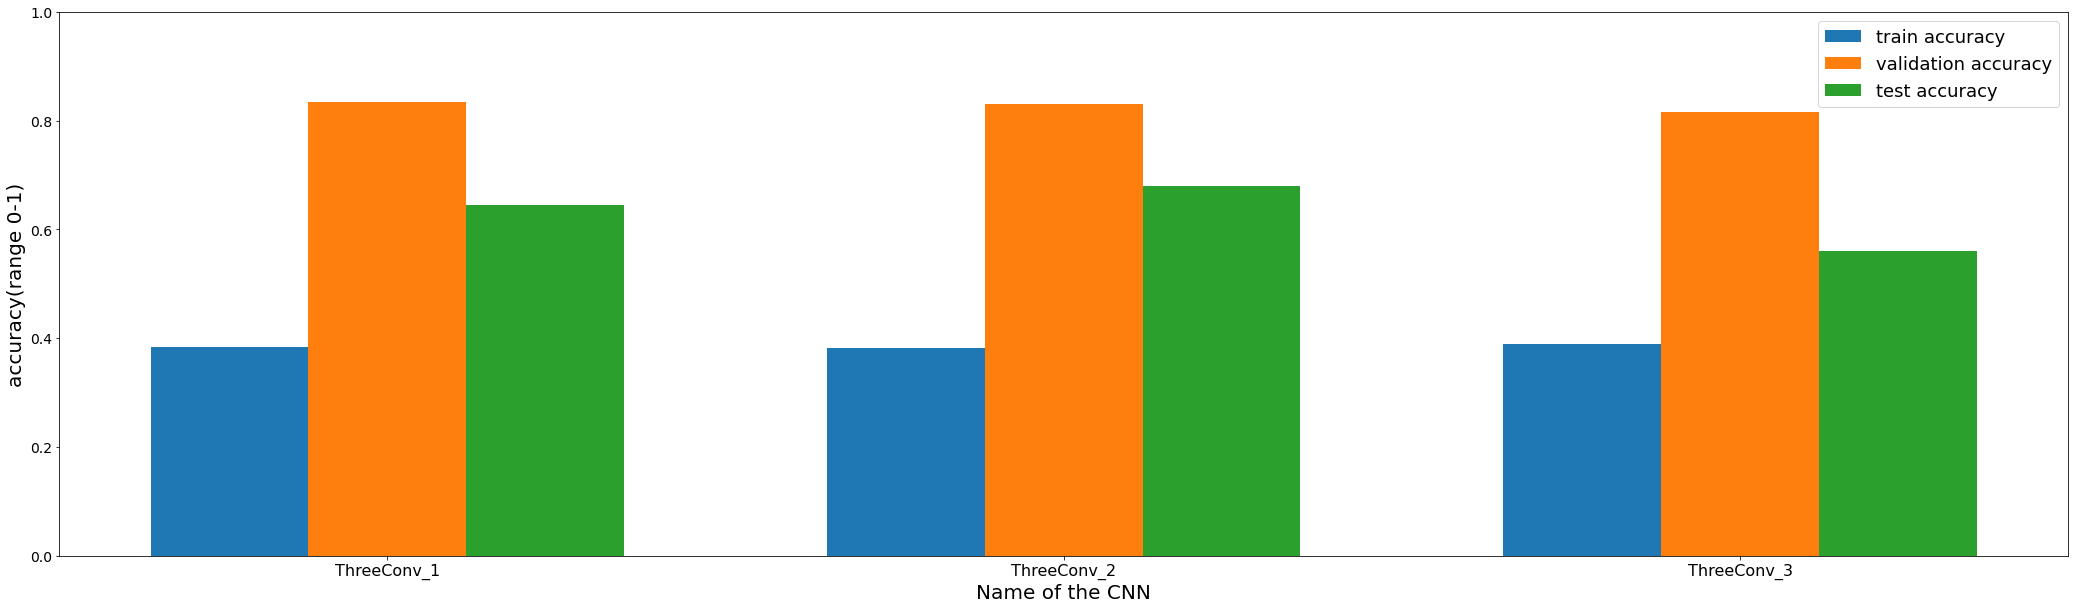

In [ ]:
#bar plot for the ThreeConv CNN configuration
subcategorybar2(cnn_results_three.iloc[:,0], [cnn_results_three.iloc[:,2],cnn_results_three.iloc[:,3], cnn_results_three.iloc[:,4]], ylim1 = 0, ylim2 = 1, labels=["train accuracy","validation accuracy","test accuracy"])

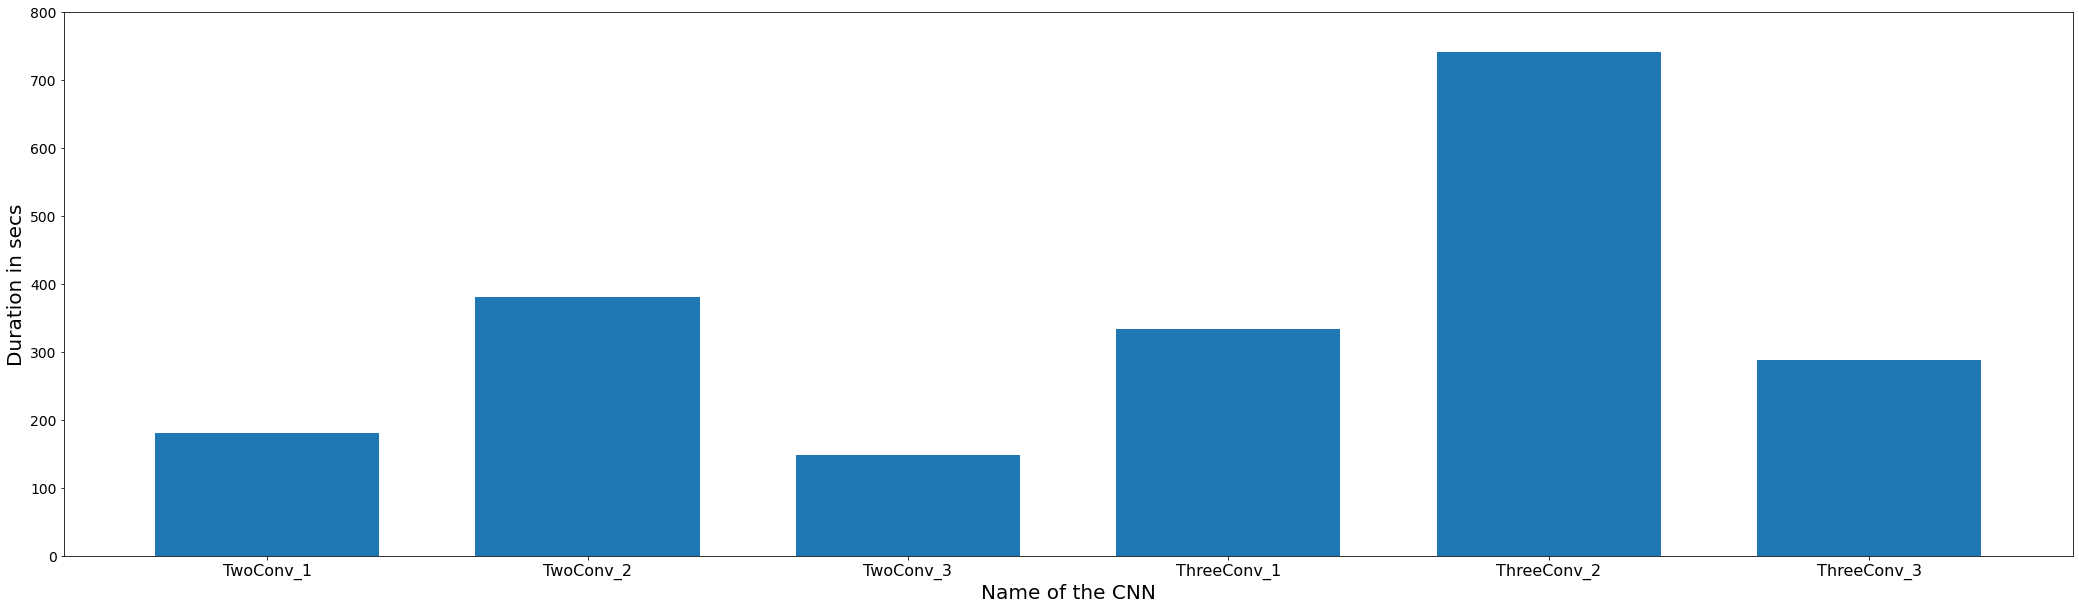

In [ ]:
#CNN training duration vs cnn type 
#manually joint data 
duration_conv3 = [180.897,380.395,148.525, 333.878,740.599,287.872]

#automatic version
#duration_conv3 = pd.concat(cnn_results_three.iloc[:,1], cnn_results.iloc[:,1])

cnn_time = ["TwoConv_1","TwoConv_2","TwoConv_3" , "ThreeConv_1","ThreeConv_2","ThreeConv_3", ]

def subcategorybar3(X, vals, labels, ylim1, ylim2, width=0.7):
    f, ax = plt.subplots(figsize=(36,10))
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X, fontsize=16)
    plt.yticks(fontsize=14)
    plt.locator_params(nbins=9)
    #plt.legend(labels=labels, fontsize=18)
    #it is used to make the results differ from each other
    plt.ylim(ylim1, ylim2)
    plt.xlabel('Name of the CNN', fontsize=20)
    plt.ylabel('Duration in secs', fontsize=20)

subcategorybar3(cnn_time, [duration_conv3], ylim1 = 0, ylim2 = 800, labels=["time(sec)"])

### C3.2 Observations

#####1. As it could be expected the three convolutional layer configurations had longer training duration. It is obviously caused by more layers and therefore more neurons, kernels, weights etc. The same situation can be noticed within the same type of CNN. TwoConv_2 had the largest number of neurons leading to the longest training time.

##### 2. As the number of epochs was limited with a chance to be not sufficient for full potential reachinge(underfitting) it was a deliberate situation which aim was to measure which type of CNN can lead to a better results. Threeconv - more parameters or twoconv-one layer less. Often more parameters allow for achieving better results but also cost more time for training. In this case it turned out that less complex two layers neural networks can outperform three layers network as set epochs allow for more precise training. 

# D. Unsupervised learning on Fashion-MNIST

## D1. Dimensionality reduction and clustering

In [ ]:
## Prepoint - import the Fashion-MNIST Dataset
#addition import of datasets from torchvision 
from torchvision import datasets
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    transforms.ToTensor()
])

#test dataset
test_data = datasets.FashionMNIST('../fashion_data', train=False,
                                  transform=data_transform, download=True)
#test dataloader
BATCH_SIZE=128
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../fashion_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../fashion_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../fashion_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../fashion_data/FashionMNIST/raw



In [ ]:
##the selected classes of cloths from the FashionMNIST are: 0 - tshirt/top and 5 - sandals
##extraction of these two classes from the dataset
sandals_dataset = [sample for sample in test_data if test_data if sample[1] == 5]
tshirt_dataset = [sample for sample in test_data if test_data if sample[1] == 0]

In [ ]:
#merging two classes into one array, spliting data into features and targets. Finally flattening the features
#flat dim is number of pixels height * width of each sample
flat_dim = 28*28

tshirt_sandal_dataset = [sample for sample in test_data if test_data if sample[1] == 0 or sample[1] == 5]
X = [np.array(image[0]).reshape(1, flat_dim) for image in tshirt_sandal_dataset]
y = [image[1] for image in tshirt_sandal_dataset]

In [ ]:
#checking if the operations were successful and printing info about subsets
print('number of datapoints in the test set: ', len(test_data))
print('number of datapoints in the tshirts/tops and sandals subset: ', len(tshirt_sandal_dataset))
print('dimensions of the sandals/tshirts images: ', tshirt_sandal_dataset[0][0].shape)

number of datapoints in the test set:  10000
number of datapoints in the tshirts/tops and sandals subset:  2000
dimensions of the sandals/tshirts images:  torch.Size([1, 28, 28])


In [ ]:
#dimensins reduction of the X array
X = np.array(X).reshape(len(tshirt_sandal_dataset), flat_dim)

In [ ]:
#first point - Apply PCA to all images of these two chosen classes.
# Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first)

#import of the PCA library and dependencies
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set random seed for numpy
np.random.seed(70629)
# Set random seed for pytorch
torch.manual_seed(70629)
random.seed(70629)

pca_model_fashion = PCA(n_components=0.95)
pca_model_fashion.fit(X)
cov_matrix = np.dot(X.T, X) / len(X)

X_pca = pca_model_fashion.transform(X)

print("=====================================")
print('Top 5 Eigenvectors in descending order:')
print("=====================================")
for pca_eigenvector in pca_model_fashion.components_[:5]:
    print('PCA Eigenvector value {}'.format(np.dot(pca_eigenvector.T, np.dot(cov_matrix, pca_eigenvector))))

Top 5 Eigenvectors in descending order:
PCA Eigenvector value 72.22465515136719
PCA Eigenvector value 19.222209930419922
PCA Eigenvector value 6.272505760192871
PCA Eigenvector value 1.9192837476730347
PCA Eigenvector value 1.5728868246078491


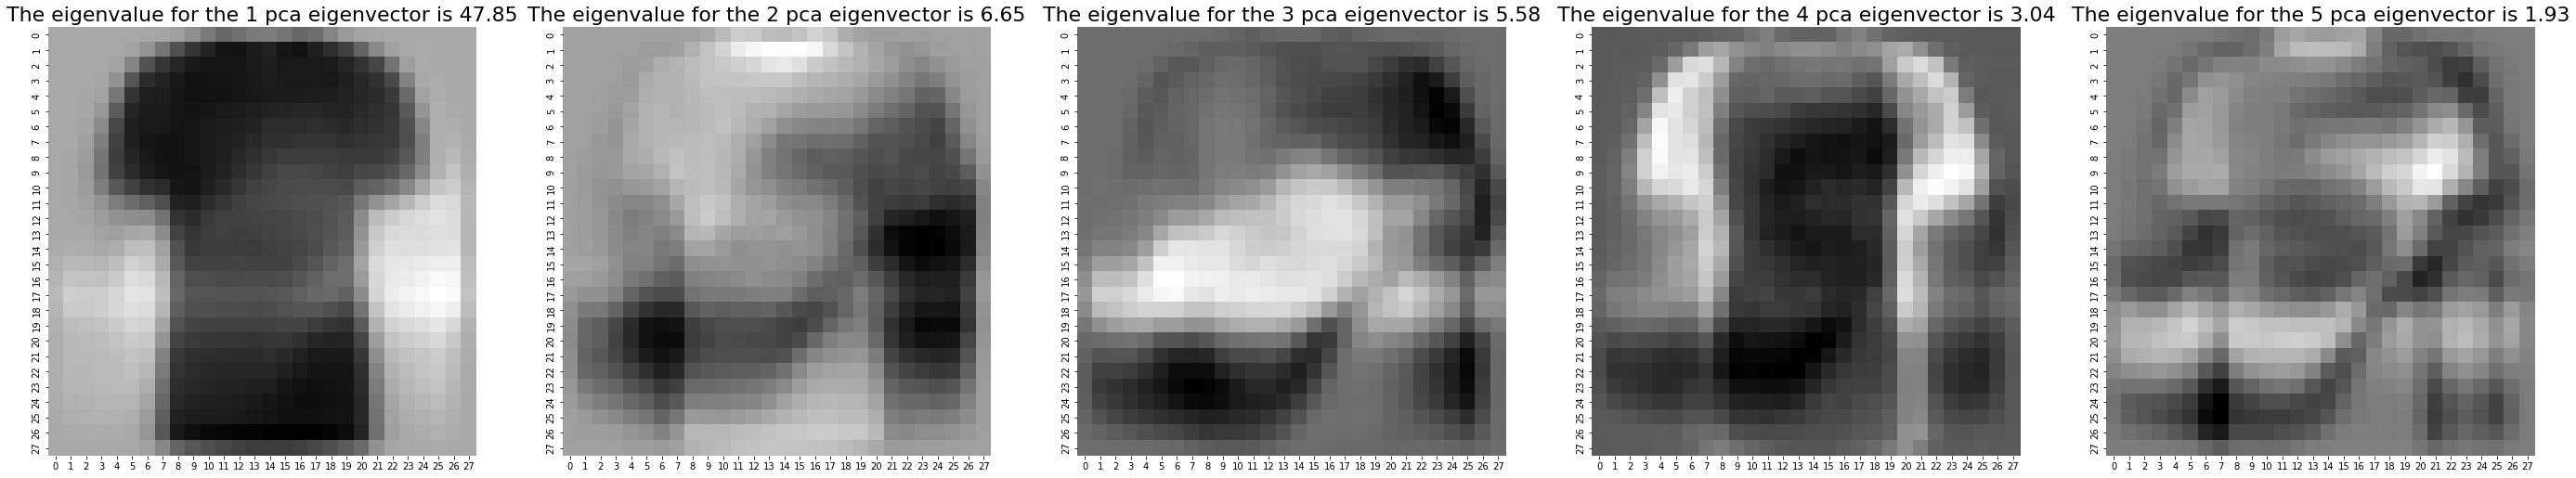

In [ ]:
#first point - Apply PCA to all images of these two chosen classes.
# Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first)

fig, axarr = plt.subplots(1, 5, figsize=(48, 32))

eigenvectors_num = 5

for i in range(eigenvectors_num):
  sns.heatmap(pca_model_fashion.components_[i, :].reshape(28, 28), ax=axarr[i], cmap='gray_r',cbar=False)

  axarr[i].set_title(
    "The eigenvalue for the {} pca eigenvector is {}".format(i+1,round(pca_model_fashion.explained_variance_ratio_[i]*100,2)),
    fontsize=22
  )
  axarr[i].set_aspect('equal')

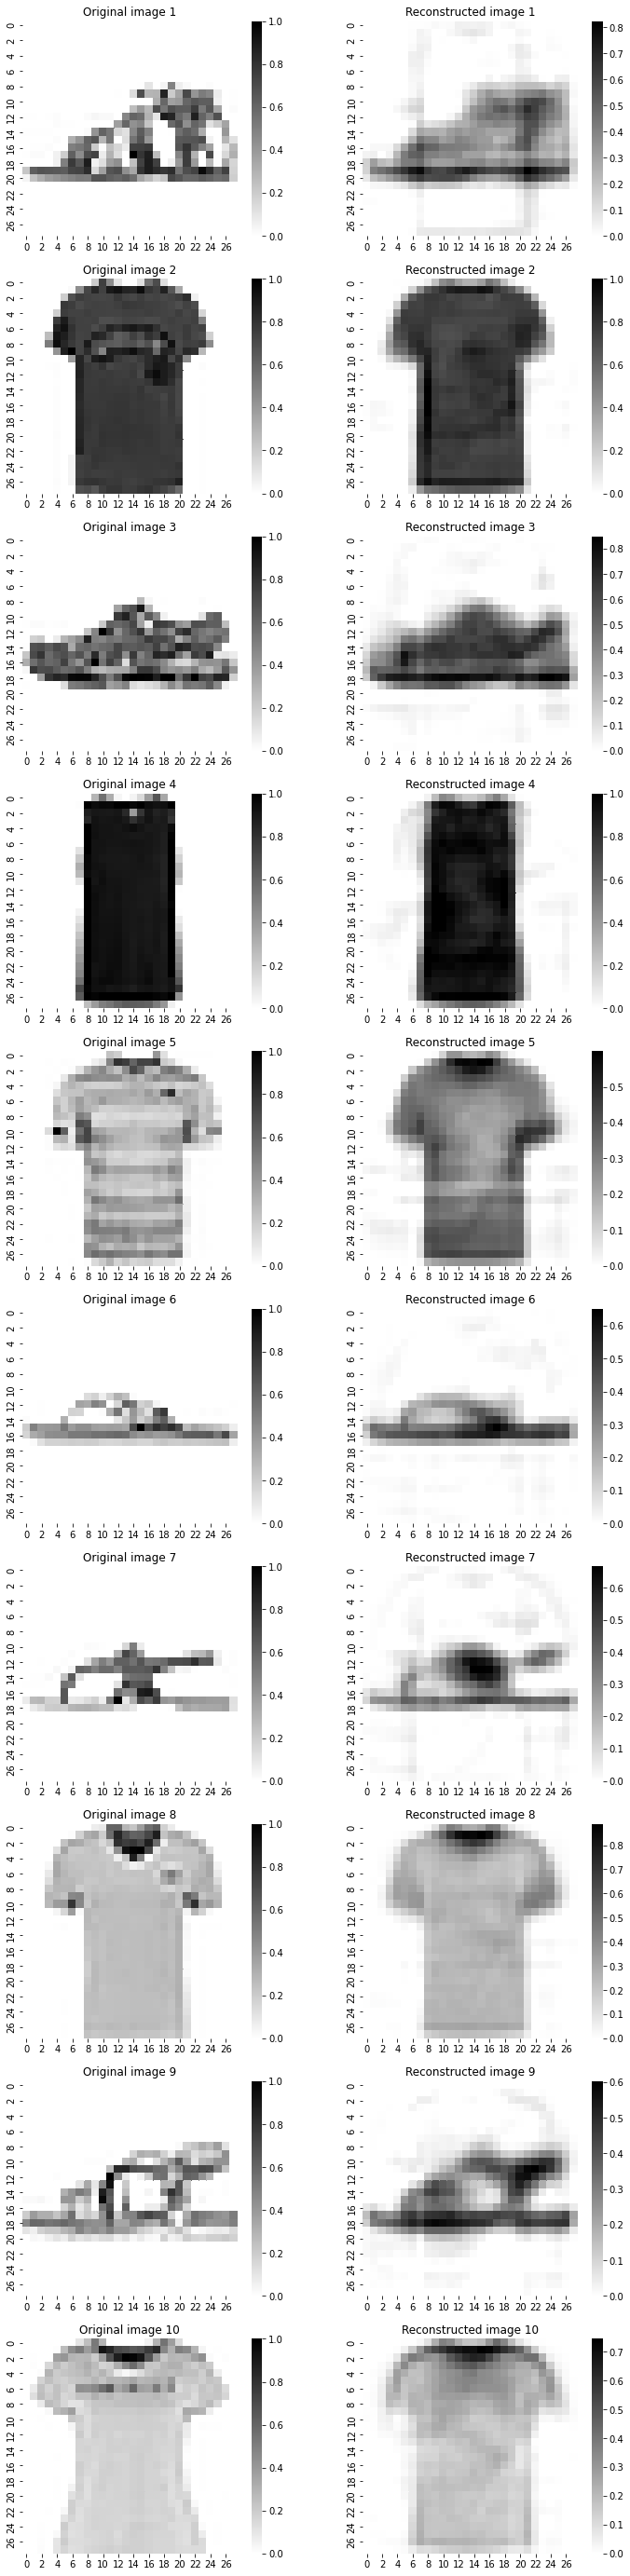

In [ ]:
#second point - Use the top 30 PCs to reconstruct 10 images, with 5 from each class (any 5 images are fine from each class). Show these 10 pairs of reconstructed and original images.

#sublots initialization
fig, axarr = plt.subplots(10, 2, figsize=(12, 50))

#PC selection num
PC_num = 30

# Set random seed for numpy
np.random.seed(70629)
# Set random seed for pytorch
torch.manual_seed(70629)
random.seed(70629)

#new PCA with 30 PC 
PCA30 = PCA(n_components=PC_num)
X_pca30 = PCA30.fit_transform(X)

#reconstruction of 5 tshirts and 5 sandals
for i in range(1,11):
  sns.heatmap(X[i, :].reshape(28, 28), cmap='gray_r'   ,
              ax=axarr[i-1][0])
  
  #PCA inverse transformation
  inversed = PCA30.inverse_transform(X_pca30[i, :])
  
  inversed[inversed < 0] = 0
  inversed[inversed > 1] = 1                                         
  sns.heatmap((inversed).reshape(28, 28), cmap='gray_r', ax=axarr[i-1][1])

  axarr[i-1, 0].set_title("Original image {}".format(i), fontsize=12)
  axarr[i-1, 1].set_title("Reconstructed image {}".format(i), fontsize=12)
  axarr[i-1][0].set_aspect('equal')
  axarr[i-1][1].set_aspect('equal')

In [ ]:
#third point - Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. using the top two PCs). 
#Use different colours/markers for the two classes for better visualisation (Hint: You need to use the class labels here for visualisation).
labels = [label[1] for label in tshirt_sandal_dataset]
labels_name = ["Tshirt" if label == 0 else "Sandals" for label in labels]

PCA_vis = pd.DataFrame()
PCA_vis["First Dimension"] = X_pca[:,0]
PCA_vis["Second Dimension"] = X_pca[:,1]
PCA_vis["labels"] = labels_name
PCA_vis["labels_num"] = labels

In [ ]:
#display
PCA_vis

,First Dimension,Second Dimension,labels,labels_num
0,-5.699315,-3.004562,Sandals,5
1,-5.027140,1.070513,Sandals,5
2,8.336565,-0.160331,Tshirt,0
3,-4.665448,1.010555,Sandals,5
4,8.214026,-0.936244,Tshirt,0
...,...,...,...,...
1995,7.451893,-0.441840,Tshirt,0
1996,3.017732,-1.752657,Tshirt,0
1997,-4.673931,1.529505,Sandals,5
1998,-2.086004,2.668011,Sandals,5


Text(0.5, 1.0, 'PCA of Sandals and Tshirts/Tops Visualization')

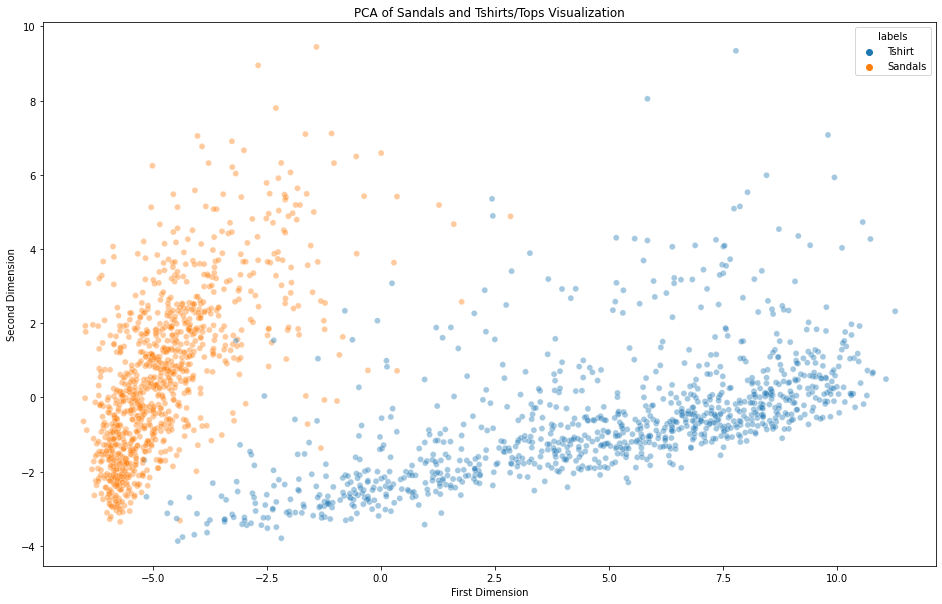

In [ ]:
#PCA 2D Plane visualization
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="First Dimension", y="Second Dimension",
    hue = "labels",
    hue_order = ['Tshirt', 'Sandals'],
    data=PCA_vis,
    alpha=0.4 
)
ax = plt.gca()
ax.set_title('PCA of Sandals and Tshirts/Tops Visualization')

In [ ]:
#forth point - Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). 
#Visualise the two clusters with different colours/markers in 2D.

#preparation of the datpoint to be clustered
clusterFrame = pd.DataFrame()
clusterFrame["first"] = PCA_vis["First Dimension"]
clusterFrame["second"] = PCA_vis["Second Dimension"]

In [ ]:
#documentation for the spectral clustering: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=70629).fit(clusterFrame)

In [ ]:
#adding the clustering prediction(number of clusters is 2 so -> 0 or 1) to the clusterFrame
clusterFrame["clustering"] = clustering.labels_

#converting 0s and 1s from clustering to labels
clusterFrame["labels"] = ["Sandals" if label == 1 else "Tshirt" for label in clusterFrame["clustering"]]

In [ ]:
#display of clusterframe
clusterFrame

,first,second,clustering,labels
0,-5.699315,-3.004562,1,Sandals
1,-5.027140,1.070513,1,Sandals
2,8.336565,-0.160331,0,Tshirt
3,-4.665448,1.010555,1,Sandals
4,8.214026,-0.936244,0,Tshirt
...,...,...,...,...
1995,7.451893,-0.441840,0,Tshirt
1996,3.017732,-1.752657,0,Tshirt
1997,-4.673931,1.529505,1,Sandals
1998,-2.086004,2.668011,1,Sandals


Text(0.5, 1.0, 'Spectral Clustering of Sandals and Tshirts/Tops Visualization')

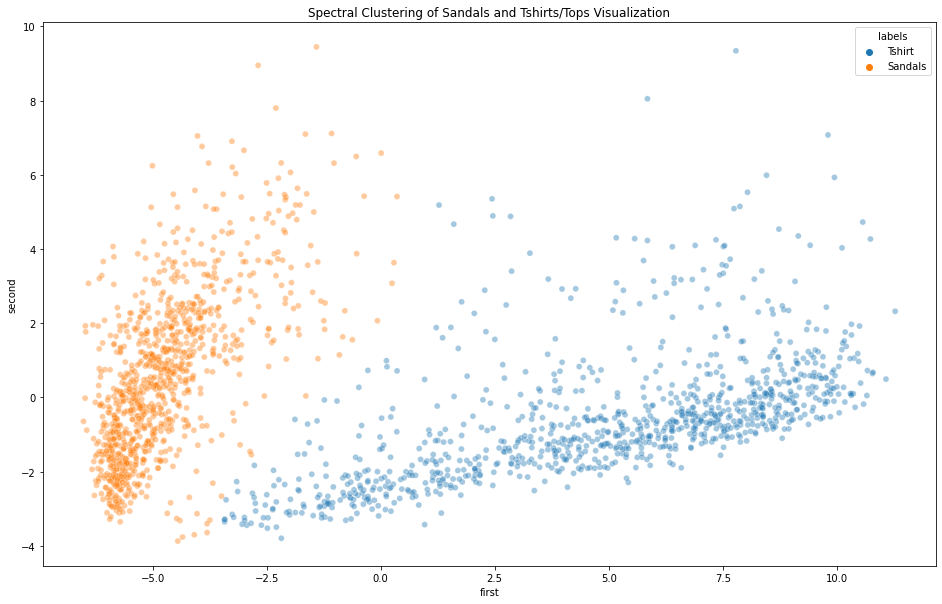

In [ ]:
#Spectral Clustering visualization
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="first", y="second",
    hue = "labels",
    hue_order = ['Tshirt', 'Sandals'],
    data=clusterFrame,
    alpha=0.4,
)
ax = plt.gca()
ax.set_title('Spectral Clustering of Sandals and Tshirts/Tops Visualization')

In [ ]:
#fifth point - Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. 
#You are free to choose the activation functions and settings such as stride and padding. 
#Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the loss against the epoch.

# Set random seed for numpy
np.random.seed(70629)
# Set random seed for pytorch
torch.manual_seed(70629)

# Create the Autoencoder module for a)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 4, 3),
            nn.ReLU(),
            nn.Conv2d(4, 8, 3),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 784, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(784, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 3),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
         
fashion_AE=Autoencoder()

In [ ]:
#fifth point part 2

fashion_AE=Autoencoder()
print(fashion_AE)

params = list(fashion_AE.parameters())
print(len(params))
print(params[0].size())  # First Conv2d's .weight
print(params[1].size())  # First Conv2d's .bias



Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 784, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(784, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
20
torch.Size([4, 1, 3, 3])
torch.Size([4])
Parameter containing:
tensor([ 0.2283,  0.2626, -0.0722, -0.2915], requires_grad=True)


In [ ]:
autoencoder_set = test_data
idx = (autoencoder_set.targets == 0) | (autoencoder_set.targets == 5)
autoencoder_set.targets = autoencoder_set.targets[idx]
autoencoder_set.data = autoencoder_set.data[idx]

In [ ]:
# Set random seed for numpy
np.random.seed(70629)
# Set random seed for pytorch
torch.manual_seed(70629)

#Training parameters
batch_size = 512
learning_rate = 0.001
epochs = 20

#Mean square error loss
loss_criterion = nn.MSELoss() 

#Adam optimiser and spliting dataset to batches
optimizer_autoencoder = torch.optim.Adam(fashion_AE.parameters(), lr = learning_rate, weight_decay = 0.00001)
batch_loader = torch.utils.data.DataLoader(trainset_b32, batch_size = batch_size, shuffle = True)

#results and lists for score storage
results_autoencoder = []
loss_results = []
index_results = []

for epoch in range(epochs):
    for data_batch in batch_loader:
        image_batch, label_batch = data_batch
        optimizer_autoencoder.zero_grad()
        output = fashion_AE(image_batch)
        loss_batch = loss_criterion(output, image_batch)
        loss_batch.backward()
        optimizer_autoencoder.step()            
    if (epoch % 1) == 0:
        print('Epoch:{}, MSELoss:{:.4f}'.format(epoch + 1, float(loss_batch)))
        loss_results.append(float(loss_batch))
        index_results.append(int(epoch + 1))
    results_autoencoder.append((epoch, image_batch, output),)

Epoch:1, MSELoss:0.0999
Epoch:2, MSELoss:0.0877
Epoch:3, MSELoss:0.0856
Epoch:4, MSELoss:0.0688
Epoch:5, MSELoss:0.0608
Epoch:6, MSELoss:0.0578
Epoch:7, MSELoss:0.0579
Epoch:8, MSELoss:0.0533
Epoch:9, MSELoss:0.0489
Epoch:10, MSELoss:0.0459
Epoch:11, MSELoss:0.0420
Epoch:12, MSELoss:0.0389
Epoch:13, MSELoss:0.0373
Epoch:14, MSELoss:0.0327
Epoch:15, MSELoss:0.0311
Epoch:16, MSELoss:0.0305
Epoch:17, MSELoss:0.0280
Epoch:18, MSELoss:0.0286
Epoch:19, MSELoss:0.0274
Epoch:20, MSELoss:0.0265


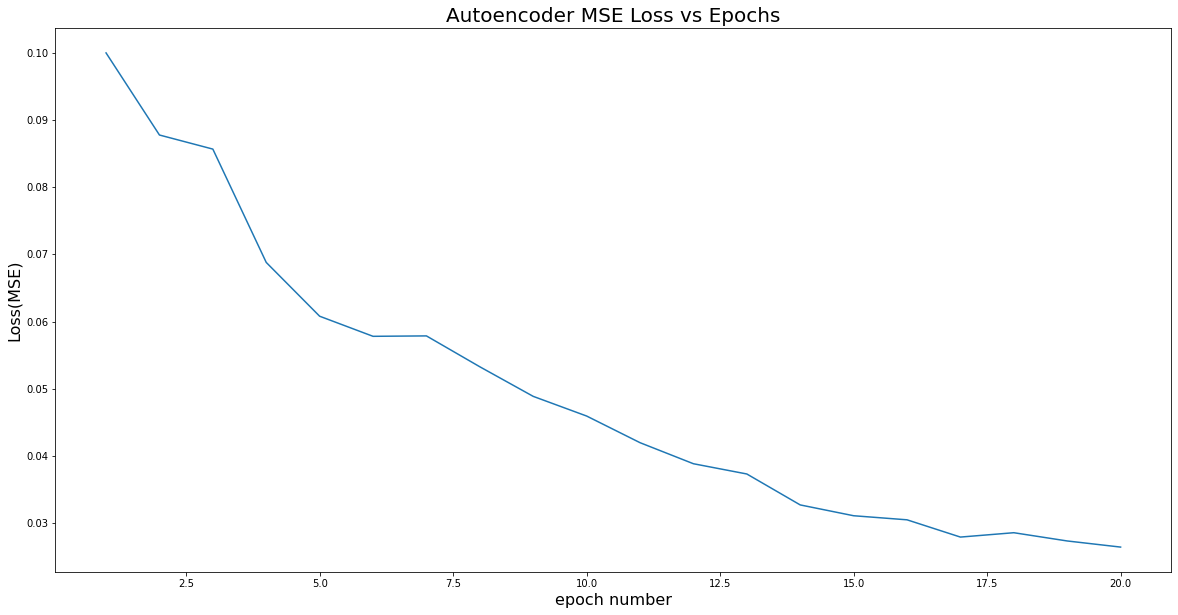

In [ ]:
###plotting the autoencoder vs epochs loss
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(index_results, loss_results)
plt.xlabel('epoch number', fontsize=16)
plt.ylabel('Loss(MSE)', fontsize=16)
plt.title('Autoencoder MSE Loss vs Epochs', fontsize=20)
plt.show()

## D2 Observation 

###Observations:

1. One of the most interesting  parts for me has been clustering. In the vast majority the point has been given the correct label and when looking for the first time PCA and spectral clustering visualizations are almost not distinguishable. It is due to perfect clustering but also chosen cloths which are grouped far from each other focused in two oval-shaped sets. However, small number of point has been given the wrong label. It can be easily explained by their ambiguous positions e.g. sandals are placed almost in the center of tshirts oval fooling the clustering and being given wrong label as a result. The other group of wronlgy clustered consists of the points being at the contact of the oval in left bottom corner. they have also been a difficult task for clustering.

2. Reconstruction of the images has also been an interesting task. From my observations based on the displayed images and other ones(not included) reconstruction of both classes has been successful in general shape recovery. 
However for both the classes the details e.g. skirt is wider at the bottom has been lost and reconstructed in thisrt shape, same as the stripes and details of the sandals.